# BT4012 Final Project 

## [1] Setting Up

#### [1.1] Import Statements

In [16]:
# import packages for data processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

# import packages for URL parsing
from urllib.parse import urlparse
from collections import Counter
import re
import tldextract
import ipaddress

# import packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# import packages for statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# import packages for model building


# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#### [1.2] Load Train Dataset

In [13]:
# load training data
df_train = pd.read_csv('dataset/train.csv')

In [14]:
df_train

url  \
0                                                                     https://www.lifewire.com/introduction-to-packet-sniffing-2486803   
1     https://support-appleld.com.secureupdate.duilawyeryork.com/ap/3e3f2c45724322d/?cmd=_update&dispatch=3e3f2c45724322d63&locale=_US   
2                                                      https://joint.co.il/forum/includes/--/https:/www.dispositivobb.com.br/login.php   
3                                  http://search.yahoo.com/tablet/s?p=australian+open+2018+dates&ei=UTF-8&fr2=p%3As%2Cv%3Aw%2Cm%3Aat-e   
4                                                                                         http://en.academic.ru/dic.nsf/enwiki/6188698   
...                                                                                                                                ...   
9139                                                                      http://aijcs.blogspot.com/2005/03/colourful-life-of-aij.html   
9140                                                                                              http://www.checkbbsms.com/index1.php   
9141                                                                                              http://holiganguncelgir.blogspot.com   
9142                                                                              https://www.emsail-live.com.ng/sr/loginform1de5.html   
9143                                                                          http://lp2m.umsu.ac.id/wp-includes/widgets/redirect.html   

      target  
0          0  
1          1  
2          1  
3          0  
4          0  
...      ...  
9139       1  
9140       1  
9141       1  
9142       1  
9143       1  

[9144 rows x 2 columns]

## [2] Feature Engineering
- At this section, we conduct feature engineering, to generate features based on URL
- All original features from the dataset were removed due to the lack of documentation on how they were created. Without clear definitions, these original features could not guarantee reproducibility, reliability, or interpretability, which are essential for a transparent and trustworthy model.
- Although many phishing datasets include additional features such as HTML-based attributes or traffic statistics, we intentionally restrict our feature set to URL-only features. This design choice ensures that the detector can be applied directly to raw URLs in real-world scenarios, where HTML content, domain metadata, or server-side information may not be easily accessible.

#### Breakdown of an URL (example)
https://subdomain.example.com:8080/path/to/file.html?key1=value1&key2=value2#section
- Scheme / Protocol: https
- Host / Domain: subdomain.example.com
    - Subdomain: subdomain
    - Second-Level-Domain (SLD): example
    - Top-Level-Domain (TLD): com
- Port: 8080
- Path: path/to/file.html
    - Directory-Path: path/to
    - Filename: file.html
    - File-Extension: html
- Query: key1=value1&key2=value2
    - Params: key1=value1 and key2=value2
- Fragment/Anchor: section

In [10]:
# decompose URL into its components
def decompose_single_url(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or None
    ext = tldextract.extract(hostname) if hostname else None
    
    return {
        'url': url,
        'protocol': parsed.scheme or None,
        'hostname': hostname,
        'subdomains': ext.subdomain if ext else None,
        'sld': ext.domain if ext else None,
        'tld': ext.suffix if ext else None,
    }

def decompose_url(df):
    df_decomposed = df['url'].apply(lambda x: pd.Series(decompose_single_url(x)))
    df_decomposed = pd.concat([df_decomposed, df['target']], axis=1)
    # convert all empty strings to None
    df_decomposed.replace('', None, inplace=True)
    # transform url such that we truncate off at hostname level
    def reconstruct_base_url(row):
        if not row['hostname']:
            return row['url']  # return original if parsing failed
        protocol = row['protocol'] if row['protocol'] else 'http'
        return f"{protocol}://{row['hostname']}"
    df_decomposed['url'] = df_decomposed.apply(reconstruct_base_url, axis=1)
    return df_decomposed

In [11]:
# feature engineering, extracting features from URL
def extract_url_features(df):

    final_df = df.copy()

    ## PROTOCOL FEATURES
    final_df['is_https'] = (final_df['protocol'] == 'https').astype(int)
    final_df['is_http'] = (final_df['protocol'] == 'http').astype(int)

    ## DOMAIN FEATURES
    final_df['has_subdomain'] = final_df['subdomains'].notna().astype(int)
    final_df['has_tld'] = final_df['tld'].notna().astype(int)
    final_df['num_subdomain'] = final_df['subdomains'].apply(lambda x: len(x.split('.')) if x else 0)
    # check if is IP address
    def is_ip_address(hostname):
        try:
            ipaddress.ip_address(hostname)
            return 1  
        except:
            return 0
    final_df['is_domain_ip'] = final_df['hostname'].apply(is_ip_address)
    # detect punycode
    final_df['is_punycode'] = final_df['hostname'].str.contains('xn--', regex=False, na=False).astype(int)

    ## LENGTH FEATURES
    final_df['length_url'] = final_df['url'].str.len()
    final_df['length_hostname'] = final_df['hostname'].str.len()
    final_df['length_subdomains'] = final_df['subdomains'].str.len()
    final_df['length_tld'] = final_df['tld'].str.len()
    final_df['length_sld'] = final_df['sld'].str.len()

    ## PUNCTUATION FEATURES
    final_df['num_dots'] = final_df['url'].str.count(r'\.')
    final_df['num_hyphens'] = final_df['url'].str.count('-')
    final_df['num_at'] = final_df['url'].str.count('@')
    final_df['num_question_marks'] = final_df['url'].str.count(r'\?')
    final_df['num_and'] = final_df['url'].str.count('&')
    final_df['num_equal'] = final_df['url'].str.count('=')
    final_df['num_underscores'] = final_df['url'].str.count('_')    
    final_df['num_slashes'] = final_df['url'].str.count('/')
    final_df['num_percent'] = final_df['url'].str.count('%')
    final_df['num_dollars'] = final_df['url'].str.count(r'\$')
    final_df['num_colon'] = final_df['url'].str.count(':')
    final_df['num_semicolon'] = final_df['url'].str.count(';')
    final_df['num_comma'] = final_df['url'].str.count(',')
    final_df['num_hashtag'] = final_df['url'].str.count('#')
    final_df['num_tilde'] = final_df['url'].str.count('~')

    ## SUSPICIOUS PATTERNS FEATURES
    final_df['tld_in_subdomain'] = final_df['subdomains'].apply(lambda x: 1 if x and any(ext in x for ext in ['.com', '.net', '.org']) else 0)
    final_df['subdomain_longer_sld'] = (final_df['length_subdomains'] > final_df['length_sld']).astype(int)

    ## RATIO FEATURES
    final_df['ratio_digits_hostname'] = final_df['hostname'].apply(lambda x: sum(c.isdigit() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_letter_hostname'] = final_df['hostname'].apply(lambda x: sum(c.isalpha() for c in x) / len(x) if len(x) > 0 else 0)
    final_df['ratio_special_char_hostname'] = final_df['hostname'].apply(lambda x: sum(not c.isalnum() and c not in ['/', ':', '.'] for c in x) / len(x) if len(x) > 0 else 0)
    
    # WORD-BASED FEATURES 
    words_host = final_df['hostname'].apply(lambda x: re.findall(r'\w+', x) if x else [])
    final_df['length_words_hostname'] = words_host.apply(len)
    final_df['avg_word_hostname'] = words_host.apply(lambda x: np.mean([len(w) for w in x]) if x else 0)

    ## CHARACTER BASED FEATURES
    final_df['num_unique_chars_hostname'] = final_df['hostname'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_unique_chars_subdomains'] = final_df['subdomains'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_unique_chars_sld'] = final_df['sld'].apply(lambda x: len(set(x)) if x else 0)
    final_df['num_non_ascii_hostname'] = final_df['hostname'].apply(lambda x: sum(1 for c in x if ord(c) > 127) if x else 0)
    final_df['longest_repeated_char_hostname'] = final_df['hostname'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)
    final_df['longest_repeated_char_subdomains'] = final_df['subdomains'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)
    final_df['longest_repeated_char_sld'] = final_df['sld'].apply(lambda x: max([len(list(g)) for k, g in re.findall(r'((.)\2*)', x)]) if x else 0)

    # URL SHORTENING FEATURES
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl', 't.co']
    final_df['has_shortened_hostname'] = final_df['hostname'].str.lower().apply(lambda x: 1 if any(service in x for service in shortening_services) else 0)
    
    # ENTROPY FEATURES
    def calculate_entropy(domain):
        if not domain or len(domain) == 0:
            return 0
        domain_clean = re.sub(r'[^a-z]', '', domain.lower())
        if len(domain_clean) == 0:
            return 0
        char_freq = Counter(domain_clean)
        entropy = -sum((count/len(domain_clean)) * np.log2(count/len(domain_clean)) 
                      for count in char_freq.values())
        return entropy
    final_df['entropy_hostname'] = final_df['hostname'].apply(calculate_entropy)
    final_df['entropy_subdomains'] = final_df['subdomains'].apply(calculate_entropy)
    final_df['entropy_sld'] = final_df['sld'].apply(calculate_entropy)

    
    return final_df

In [12]:
# section 2 function
def run_section_2(df):
    df_decomposed = decompose_url(df)
    df_features = extract_url_features(df_decomposed)
    return df_features

In [17]:
df_train = run_section_2(df_train)

## [3] Preliminary Data Exploration and Preprocessing
- At this section, we conduct some basic data inspection before doing EDA. This includes checking for missing, duplicated rows, data types, as well as removing columns that hold no predictive meaning

#### [2.1] Data Inspection

In [18]:
# check first few rows
df_train.head()

url protocol  \
0                                    https://www.lifewire.com    https   
1  https://support-appleld.com.secureupdate.duilawyeryork.com    https   
2                                         https://joint.co.il    https   
3                                     http://search.yahoo.com     http   
4                                       http://en.academic.ru     http   

                                             hostname  \
0                                    www.lifewire.com   
1  support-appleld.com.secureupdate.duilawyeryork.com   
2                                         joint.co.il   
3                                    search.yahoo.com   
4                                      en.academic.ru   

                         subdomains            sld    tld  target  is_https  \
0                               www       lifewire    com       0         1   
1  support-appleld.com.secureupdate  duilawyeryork    com       1         1   
2                              None          joint  co.il       1         1   
3                            search          yahoo    com       0         0   
4                                en       academic     ru       0         0   

   is_http  has_subdomain  has_tld  num_subdomain  is_domain_ip  is_punycode  \
0        0              1        1              1             0            0   
1        0              1        1              3             0            0   
2        0              0        1              0             0            0   
3        1              1        1              1             0            0   
4        1              1        1              1             0            0   

   length_url  length_hostname  length_subdomains  length_tld  length_sld  \
0          24               16                3.0         3.0           8   
1          58               50               32.0         3.0          13   
2          19               11                NaN         5.0           5   
3          23               16                6.0         3.0           5   
4          21               14                2.0         2.0           8   

   num_dots  num_hyphens  num_at  num_question_marks  num_and  num_equal  \
0         2            0       0                   0        0          0   
1         4            1       0                   0        0          0   
2         2            0       0                   0        0          0   
3         2            0       0                   0        0          0   
4         2            0       0                   0        0          0   

   num_underscores  num_slashes  num_percent  num_dollars  num_colon  \
0                0            2            0            0          1   
1                0            2            0            0          1   
2                0            2            0            0          1   
3                0            2            0            0          1   
4                0            2            0            0          1   

   num_semicolon  num_comma  num_hashtag  num_tilde  tld_in_subdomain  \
0              0          0            0          0                 0   
1              0          0            0          0                 1   
2              0          0            0          0                 0   
3              0          0            0          0                 0   
4              0          0            0          0                 0   

   subdomain_longer_sld  ratio_digits_hostname  ratio_letter_hostname  \
0                     0                    0.0               0.875000   
1                     1                    0.0               0.900000   
2                     0                    0.0               0.818182   
3                     1                    0.0               0.875000   
4                     0                    0.0               0.857143   

   ratio_special_char_hostname  length_words_hostname  avg_word_hostname  \
0      

In [19]:
# check shape of dataset
df_train.shape

(9144, 52)

In [20]:
# check for duplicate rows
df_train.duplicated().sum()

np.int64(2219)

In [21]:
# print out duplicated rows, keep all
df_train[df_train.duplicated(keep=False)].sort_values(by='url')

url protocol                    hostname  \
4114       http://03418f6.netsolhost.com     http      03418f6.netsolhost.com   
2625       http://03418f6.netsolhost.com     http      03418f6.netsolhost.com   
1214                http://107.180.44.78     http               107.180.44.78   
8500                http://107.180.44.78     http               107.180.44.78   
8834                http://107.180.44.78     http               107.180.44.78   
...                                  ...      ...                         ...   
2486  https://y80yyxccn.df.r.appspot.com    https  y80yyxccn.df.r.appspot.com   
5326        https://y9o5m.codesandbox.io    https        y9o5m.codesandbox.io   
1499        https://y9o5m.codesandbox.io    https        y9o5m.codesandbox.io   
1298                https://zabor-vn.com    https                zabor-vn.com   
5198                https://zabor-vn.com    https                zabor-vn.com   

          subdomains            sld   tld  target  is_https  is_http  \
4114         03418f6     netsolhost   com       1         0        1   
2625         03418f6     netsolhost   com       1         0        1   
1214            None  107.180.44.78  None       1         0        1   
8500            None  107.180.44.78  None       1         0        1   
8834            None  107.180.44.78  None       1         0        1   
...              ...            ...   ...     ...       ...      ...   
2486  y80yyxccn.df.r        appspot   com       1         1        0   
5326           y9o5m    codesandbox    io       1         1        0   
1499           y9o5m    codesandbox    io       1         1        0   
1298            None       zabor-vn   com       1         1        0   
5198            None       zabor-vn   com       1         1        0   

      has_subdomain  has_tld  num_subdomain  is_domain_ip  is_punycode  \
4114              1        1              1             0            0   
2625              1        1              1             0            0   
1214              0        0              0             1            0   
8500              0        0              0             1            0   
8834              0        0              0             1            0   
...             ...      ...            ...           ...          ...   
2486              1        1              3             0            0   
5326              1        1              1             0            0   
1499              1        1              1             0            0   
1298              0        1              0             0            0   
5198              0        1              0             0            0   

      length_url  length_hostname  length_subdomains  length_tld  length_sld  \
4114          29               22                7.0         3.0          10   
2625          29               22                7.0         3.0          10   
1214          20               13                NaN         NaN          13   
8500          20               13                NaN         NaN          13   
8834          20               13                NaN         NaN          13   
...          ...              ...                ...         ...         ...   
2486          34               26               14.0         3.0           7   
5326          28               20                5.0         2.0          11   
1499          28               20                5.0         2.0          11   
1298          20               12                NaN         3.0           8   
5198          20               12                NaN         3.0           8   

      num_dots  num_hyphens  num_at  num_question_marks  num_and  num_equal  \
4114         2            0       0                   0        0          0   
2625         2            0       0                   0        0          0   
1214         3            0       0                   0        0          0   
8500         3            0      

In [25]:
# check if duplicated rows have different target labels, print out the rows that do
duplicated_urls = df_train[df_train.duplicated(subset=['url'], keep=False)]
duplicated_check = duplicated_urls.groupby('url')['target'].nunique()
conflicting_duplicates = duplicated_check[duplicated_check > 1].index.tolist()
df_train[df_train['url'].isin(conflicting_duplicates)].sort_values(by='url')

url protocol                   hostname  \
5627  https://login.microsoftonline.com    https  login.microsoftonline.com   
3404  https://login.microsoftonline.com    https  login.microsoftonline.com   
2163  https://login.microsoftonline.com    https  login.microsoftonline.com   
7912  https://login.microsoftonline.com    https  login.microsoftonline.com   
7776            https://play.google.com    https            play.google.com   
...                                 ...      ...                        ...   
5784            https://www.youtube.com    https            www.youtube.com   
667             https://www.youtube.com    https            www.youtube.com   
6108            https://www.youtube.com    https            www.youtube.com   
3902            https://www.youtube.com    https            www.youtube.com   
8980            https://www.youtube.com    https            www.youtube.com   

     subdomains              sld  tld  target  is_https  is_http  \
5627      login  microsoftonline  com       0         1        0   
3404      login  microsoftonline  com       0         1        0   
2163      login  microsoftonline  com       1         1        0   
7912      login  microsoftonline  com       0         1        0   
7776       play           google  com       0         1        0   
...         ...              ...  ...     ...       ...      ...   
5784        www          youtube  com       0         1        0   
667         www          youtube  com       0         1        0   
6108        www          youtube  com       0         1        0   
3902        www          youtube  com       0         1        0   
8980        www          youtube  com       0         1        0   

      has_subdomain  has_tld  num_subdomain  is_domain_ip  is_punycode  \
5627              1        1              1             0            0   
3404              1        1              1             0            0   
2163              1        1              1             0            0   
7912              1        1              1             0            0   
7776              1        1              1             0            0   
...             ...      ...            ...           ...          ...   
5784              1        1              1             0            0   
667               1        1              1             0            0   
6108              1        1              1             0            0   
3902              1        1              1             0            0   
8980              1        1              1             0            0   

      length_url  length_hostname  length_subdomains  length_tld  length_sld  \
5627          33               25                5.0         3.0          15   
3404          33               25                5.0         3.0          15   
2163          33               25                5.0         3.0          15   
7912          33               25                5.0         3.0          15   
7776          23               15                4.0         3.0           6   
...          ...              ...                ...         ...         ...   
5784          23               15                3.0         3.0           7   
667           23               15                3.0         3.0           7   
6108          23               15                3.0         3.0           7   
3902          23               15                3.0         3.0           7   
8980          23               15                3.0         3.0           7   

      num_dots  num_hyphens  num_at  num_question_marks  num_and  num_equal  \
5627         2            0       0                   0        0          0   
3404         2            0       0                   0        0          0   
2163         2            0       0                   0        0          0   
7912         2            0       0                   0        0          0   
7776         2           

In [35]:
# check for null 
df_train.isna().sum()

FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
URLTitle

In [36]:
# check data type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165056 entries, 0 to 165055
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    165056 non-null  object 
 1   URL                         165056 non-null  object 
 2   URLLength                   165056 non-null  int64  
 3   Domain                      165056 non-null  object 
 4   DomainLength                165056 non-null  int64  
 5   IsDomainIP                  165056 non-null  int64  
 6   TLD                         165056 non-null  object 
 7   URLSimilarityIndex          165056 non-null  float64
 8   CharContinuationRate        165056 non-null  float64
 9   TLDLegitimateProb           165056 non-null  float64
 10  URLCharProb                 165056 non-null  float64
 11  TLDLength                   165056 non-null  int64  
 12  NoOfSubDomain               165056 non-null  int64  
 13  HasObfuscation

Insights:
- `FILENAME` column is used internally by the owner of the dataset as a reference id and is not applicable for our use case, thus we can remove it
- There are no duplicated data and no null data thus no further processing is required
- There are float, int and object data types. Some fields seems to be boolean but are stored as int64

Plan:
- Drop `FILENAME` column
- Convert boolean columns to the correct data type to facilitate downstream use cases

#### [2.2] Drop unnecessary columns and convert data types

In [48]:
def preprocess_data(df):
    # drop FILENAME column
    df = df.drop(columns=['FILENAME'])
    
    # convert boolean columns to 'bool' data type
    bool_columns = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon',
                    'Robots', 'IsResponsive', 'HasDescription', 'HasExternalFormSubmit',
                    'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields','HasPasswordField',
                    'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo']
    for col in bool_columns:
        df[col] = df[col].astype(bool)
    
    return df

In [77]:
df_train = preprocess_data(df_train)

In [50]:
df_train

URL  URLLength  \
0                     https://api.auth.gg/         19   
1            https://www.polisci.upenn.edu         28   
2             https://www.oscarhunt.com.au         27   
3            https://www.crowncabinets.com         28   
4            https://www.robertlpeters.com         28   
...                                    ...        ...   
165051       https://www.thejusticegap.com         28   
165052        https://www.millisavunma.com         27   
165053  https://hzlt1adwk.firebaseapp.com/         34   
165054           http://globalmetamask.com         25   
165055          https://www.tracesofwar.nl         25   

                           Domain  DomainLength  IsDomainIP  TLD  \
0                     api.auth.gg            11       False   gg   
1           www.polisci.upenn.edu            21       False  edu   
2            www.oscarhunt.com.au            20       False   au   
3           www.crowncabinets.com            21       False  com   
4           www.robertlpeters.com            21       False  com   
...                           ...           ...         ...  ...   
165051      www.thejusticegap.com            21       False  com   
165052       www.millisavunma.com            20       False  com   
165053  hzlt1adwk.firebaseapp.com            25       False  com   
165054         globalmetamask.com            18       False  com   
165055         www.tracesofwar.nl            18       False   nl   

        URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  \
0                66.666667              0.625000           0.000178   
1               100.000000              0.615385           0.011501   
2               100.000000              0.769231           0.010086   
3               100.000000              1.000000           0.522907   
4               100.000000              1.000000           0.522907   
...                    ...                   ...                ...   
165051          100.000000              1.000000           0.522907   
165052          100.000000              1.000000           0.522907   
165053           71.212308              0.619048           0.522907   
165054           78.037687              1.000000           0.522907   
165055          100.000000              1.000000           0.008200   

        URLCharProb  TLDLength  NoOfSubDomain  HasObfuscation  \
0          0.046504          2              1           False   
1          0.057601          3              2           False   
2          0.066248          2              2           False   
3          0.065279          3              1           False   
4          0.065927          3              1           False   
...             ...        ...            ...             ...   
165051     0.056816          3              1           False   
165052     0.059284          3              1           False   
165053     0.048478          3              1           False   
165054     0.062371          3              0           False   
165055     0.062157          2              1           False   

        NoOfObfuscatedChar  ObfuscationRatio  NoOfLettersInURL  \
0                        0               0.0                 9   
1                        0               0.0                14   
2                        0               0.0                13   
3                        0               0.0                15   
4                        0               0.0                15   
...                    ...               ...               ...   
165051                   0               0.0                15   
165052                   0               0.0                14   
165053                   0               0.0                22   
165054                   0               0.0                17   
165055                   0               0.0                12   

        LetterRatioInURL  NoOfDegitsInURL  DegitRatioInURL  NoOfEqualsInURL  \
0                  0.474       

## [3] Exploratory Data Analysis
- At this section, we conduct the EDA
- A structured approach is followed, looking at descriptive analysis for numerical and categorical / binary variables as well as outlier analysis first. The purpose is to better understand each variable distribution, and see if any further processing is needed, such as transformation or scaling.
- Then, we conducted qualitative and quantitative correlation analysis. The purpose was to understand the relationship between features as well as the relationship between features with the target, and see if any further processing is needed, such as removing of highly correlated features or features with limited predictive power.
- Lastly, we also conducted EDA on the text features

#### [3.1] Descriptive Analysis for numerical variables

In [52]:
# get numerical variables and calculate summary statistics
numerical_variables = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_variables.remove('label')  
descriptive_stats_numerical = df_train[numerical_variables].describe().T
descriptive_stats_numerical['mode'] = df_train[numerical_variables].mode().transpose()[0]
descriptive_stats_numerical['mad'] = [stats.median_abs_deviation(df_train[x]) for x in numerical_variables]
descriptive_stats_numerical['kurtosis'] = [stats.kurtosis(df_train[x], fisher=True) for x in numerical_variables]
descriptive_stats_numerical['skewness'] = [stats.skew(df_train[x]) for x in numerical_variables]
descriptive_stats_numerical

count          mean            std        min  \
URLLength                   165056.0     34.545615      37.823276  13.000000   
DomainLength                165056.0     21.450508       9.114669   4.000000   
URLSimilarityIndex          165056.0     78.453770      28.975749   0.197141   
CharContinuationRate        165056.0      0.845860       0.216367   0.000000   
TLDLegitimateProb           165056.0      0.260556       0.251639   0.000000   
URLCharProb                 165056.0      0.055758       0.010573   0.001083   
TLDLength                   165056.0      2.764504       0.599295   2.000000   
NoOfSubDomain               165056.0      1.163981       0.600655   0.000000   
NoOfObfuscatedChar          165056.0      0.022265       1.420197   0.000000   
ObfuscationRatio            165056.0      0.000143       0.003916   0.000000   
NoOfLettersInURL            165056.0     19.424807      27.020037   0.000000   
LetterRatioInURL            165056.0      0.516154       0.123287   0.000000   
NoOfDegitsInURL             165056.0      1.863816      10.337409   0.000000   
DegitRatioInURL             165056.0      0.028537       0.070747   0.000000   
NoOfEqualsInURL             165056.0      0.060634       0.807448   0.000000   
NoOfQMarkInURL              165056.0      0.029632       0.193938   0.000000   
NoOfAmpersandInURL          165056.0      0.023992       0.744664   0.000000   
NoOfOtherSpecialCharsInURL  165056.0      2.336625       3.282957   0.000000   
SpacialCharRatioInURL       165056.0      0.063257       0.032375   0.000000   
LineOfCode                  165056.0   1152.830845    3725.116653   2.000000   
LargestLineLength           165056.0  12734.663890  149917.793578  22.000000   
DomainTitleMatchScore       165056.0     50.201688      49.670943   0.000000   
URLTitleMatchScore          165056.0     52.209248      49.591236   0.000000   
NoOfURLRedirect             165056.0      0.133028       0.339606   0.000000   
NoOfSelfRedirect            165056.0      0.040198       0.196425   0.000000   
NoOfPopup                   165056.0      0.219404       3.821681   0.000000   
NoOfiFrame                  165056.0      1.600954       6.222000   0.000000   
NoOfImage                   165056.0     26.179357      77.829287   0.000000   
NoOfCSS                     165056.0      6.390867      89.125211   0.000000   
NoOfJS                      165056.0     10.467956      16.030412   0.000000   
NoOfSelfRef                 165056.0     65.346694     187.011411   0.000000   
NoOfEmptyRef                165056.0      2.386226      18.930608   0.000000   
NoOfExternalRef             165056.0     49.463679     173.066911   0.000000   

                                   25%          50%          75%  \
URLLength                    23.000000    27.000000    34.000000   
DomainLength                 16.000000    20.000000    24.000000   
URLSimilarityIndex           57.115010   100.000000   100.000000   
CharContinuationRate          0.680000     1.000000     1.000000   
TLDLegitimateProb             0.005977     0.079963     0.522907   
URLCharProb                   0.050774     0.057973     0.062875   
TLDLength                     2.000000     3.000000     3.000000   
NoOfSubDomain                 1.000000     1.000000     1.000000   
NoOfObfuscatedChar            0.000000     0.000000     0.000000   
ObfuscationRatio              0.000000     0.000000     0.000000   
NoOfLettersInURL             10.000000    14.000000    20.000000   
LetterRatioInURL              0.435000     0.519000     0.594000   
NoOfDegitsInURL               0.000000     0.000000     0.000000   
DegitRatioInURL               0.000000     0.000000     0.000000   
NoOfEqualsInURL               0.000000     0.000000     0.000000   
NoOfQMarkInURL                0.000000     0.000000     0.000000   
NoOfAmpersandInURL            0.000000     0.000000     0.000000   
NoOfOtherSpecialCharsInURL    1.000000     1.000000     3.000000   
SpacialCharRatioIn

Insights:
- Columns like `NoOfObfuscatedChar`, `NoOfDegitsInURL`, `NoOfEqualsInURL`, `NoOfAmpersandInURL`, `NoOfiFrame`, `NoOfCSS`, `NoOfEmptyRef` are highly skewed 
- Columns like `LineOfCode` and `LargestLineLength` seems to be on a very different scale compared to the other variables 

Plan:
- For models like logistic regression, can perform relevant transformation to change the distribution of the data, making skewed features closer to normal distribution, in order to improve the performance of the model
- For distance based models that are sensitive to scale like SVM or models that rely on gradient descent, can perform scaling of features for more accurate computations and to improve speed of convergence

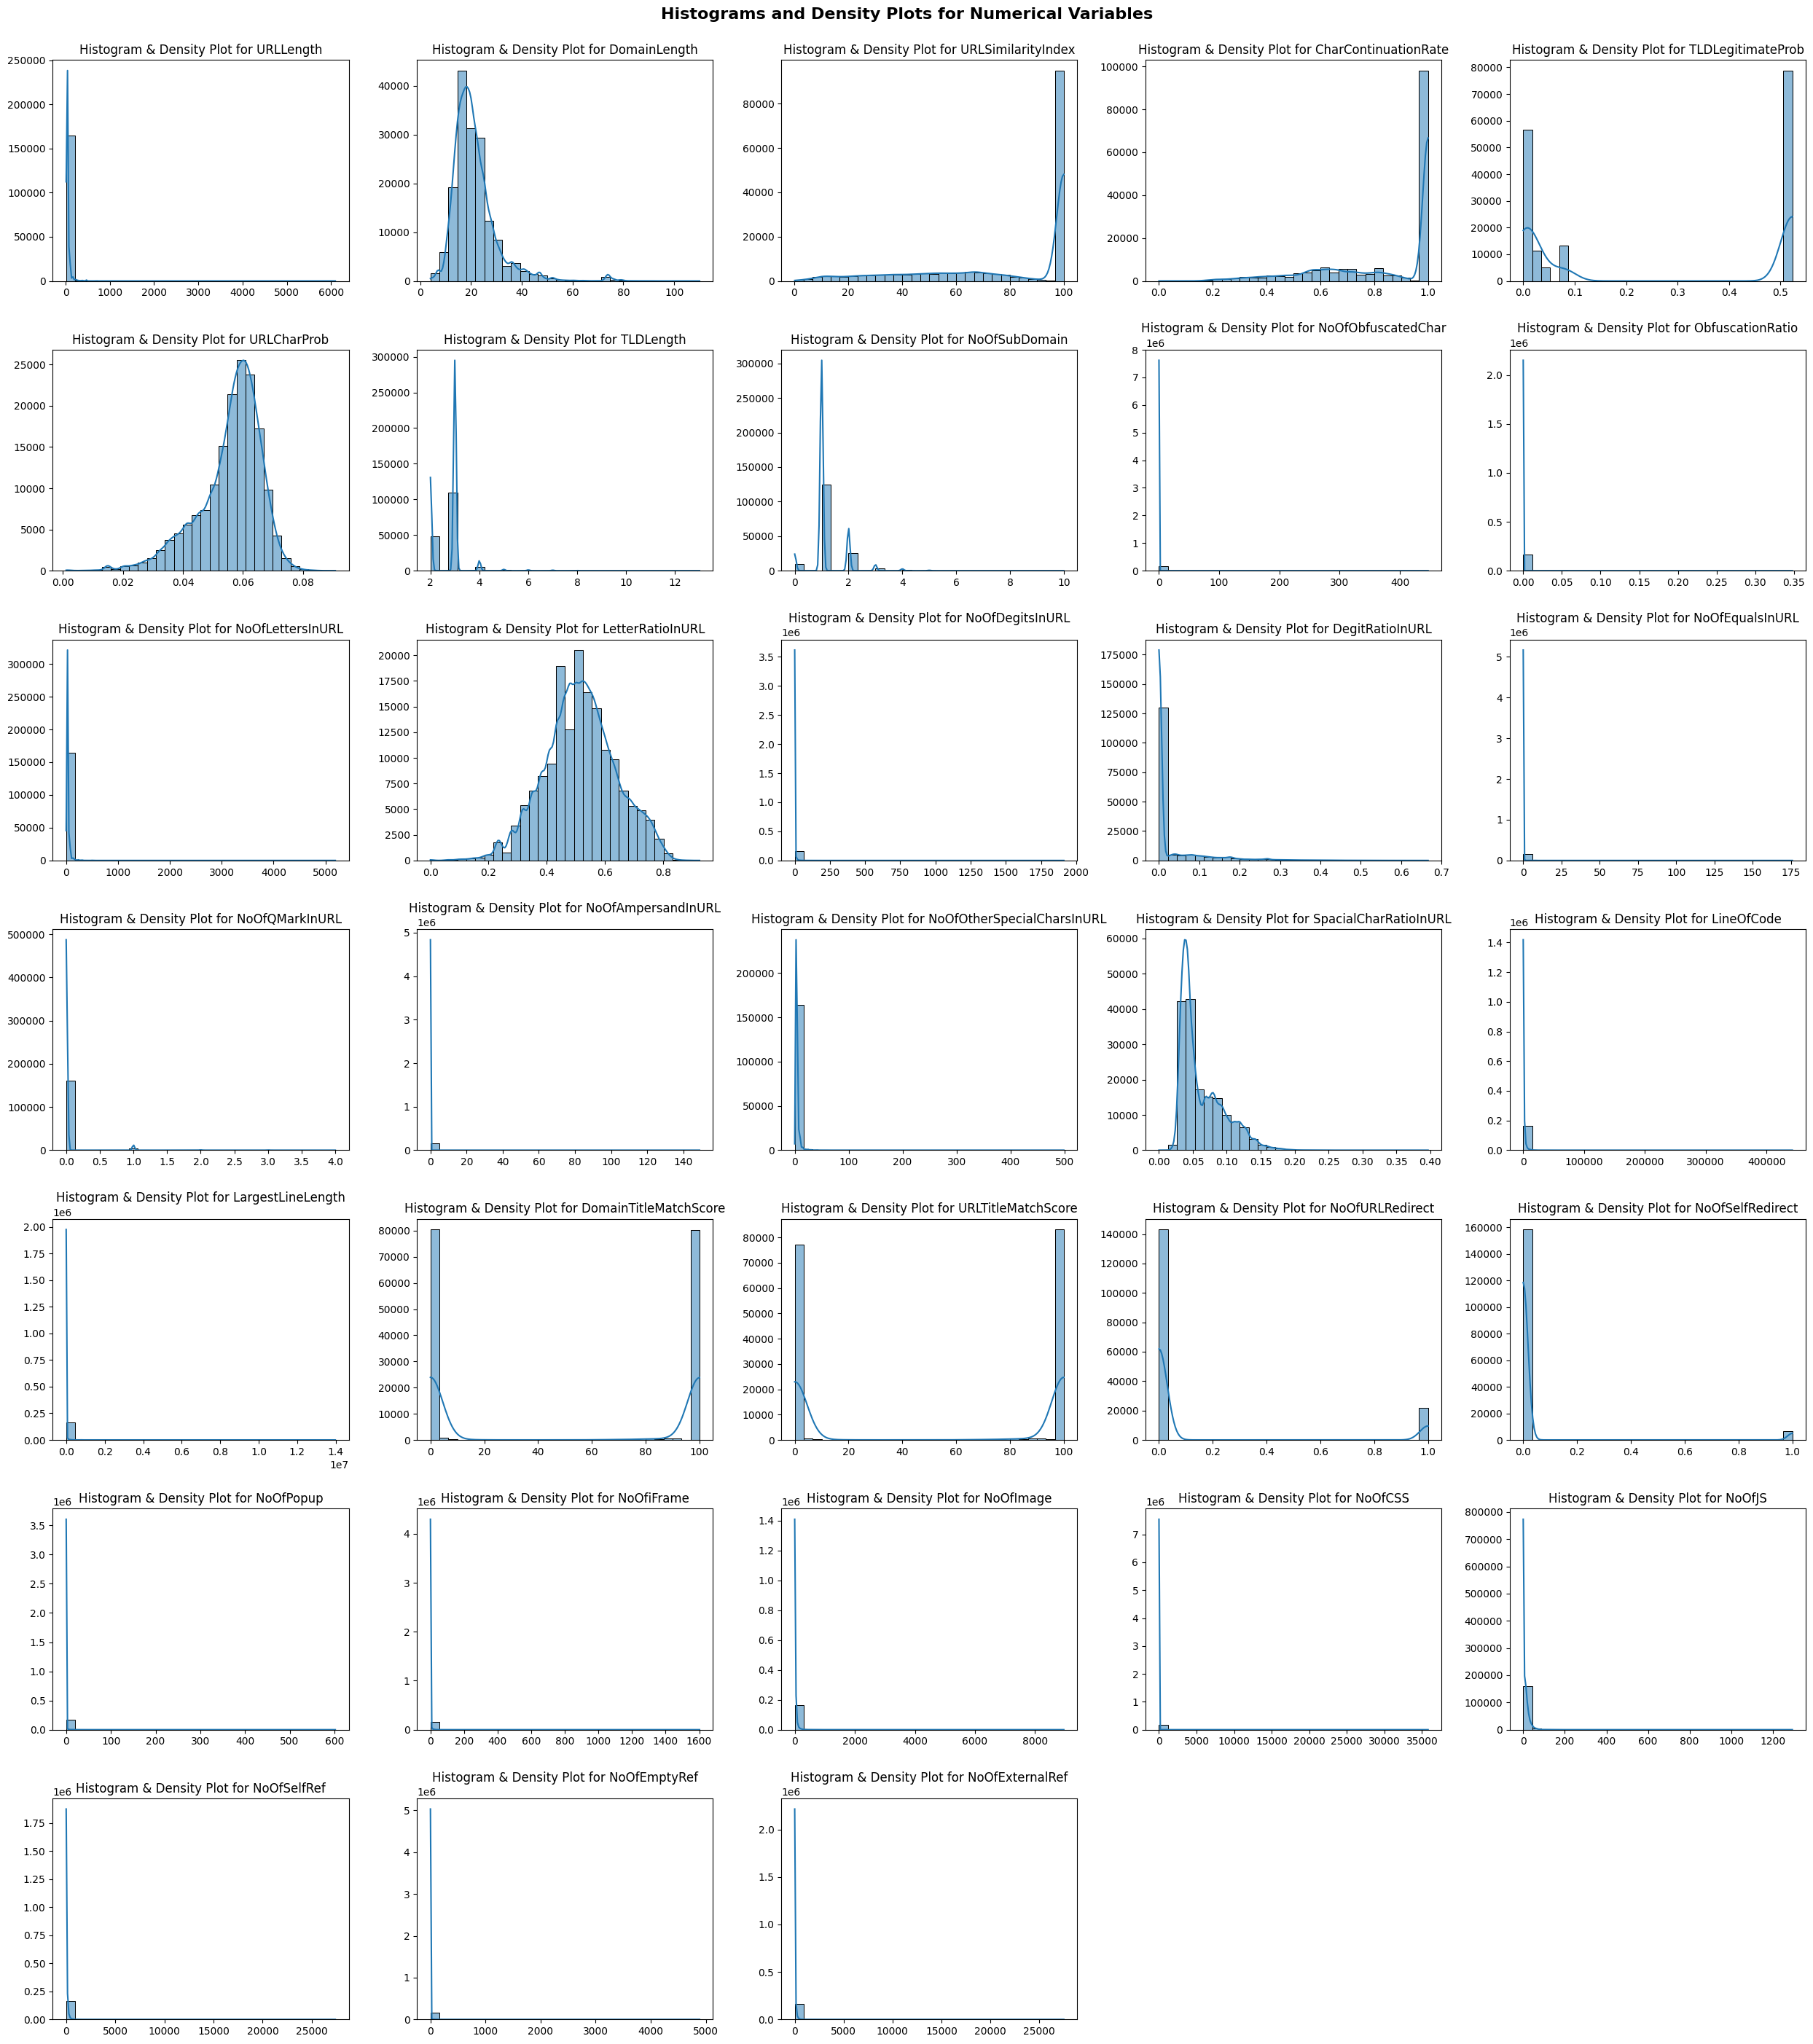

In [ ]:
# plot histograms and kde for numerical variables
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(5 * 5, 7 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Numerical Variables', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(numerical_variables):
    ax = axes[i]
    sns.histplot(data=df_train, x=var_name, kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for {var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(numerical_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()

Insights:
- There are quite a lot of columns that are heavily right skewed like with only an extreme left peak eg. `NoOfQMarkInURL`, `NoOfOtherSpecialCharsInURL`, where there seems to be a large amount of outliers present.
- There are also some columns that are moderately right skewed like eg. `DomainLength`, `SpacialCharRatioInURL`.
- There are some columns that have a bimodal distribution with extreme left and extreme right peaks like eg. `DomainTitleMatchScore`, `TLDLegitimateProb`.
- There are some columns that are left skewed like eg. `URLSimilarityIndex` and `CharContinuationRate`
- Lastly, columns like `URLCharProb` and `LetterRatioInURL` seem to be rather normally distributed

Plan:
- We can try a log transform or use other transformation technique to make the variables that are right skewed more normally distributed
- For bimodal columns, we can leave it as it is already separating the data into two clear distinct group which is ideal

##### [3.1.1] Apply Transformation and Visualise

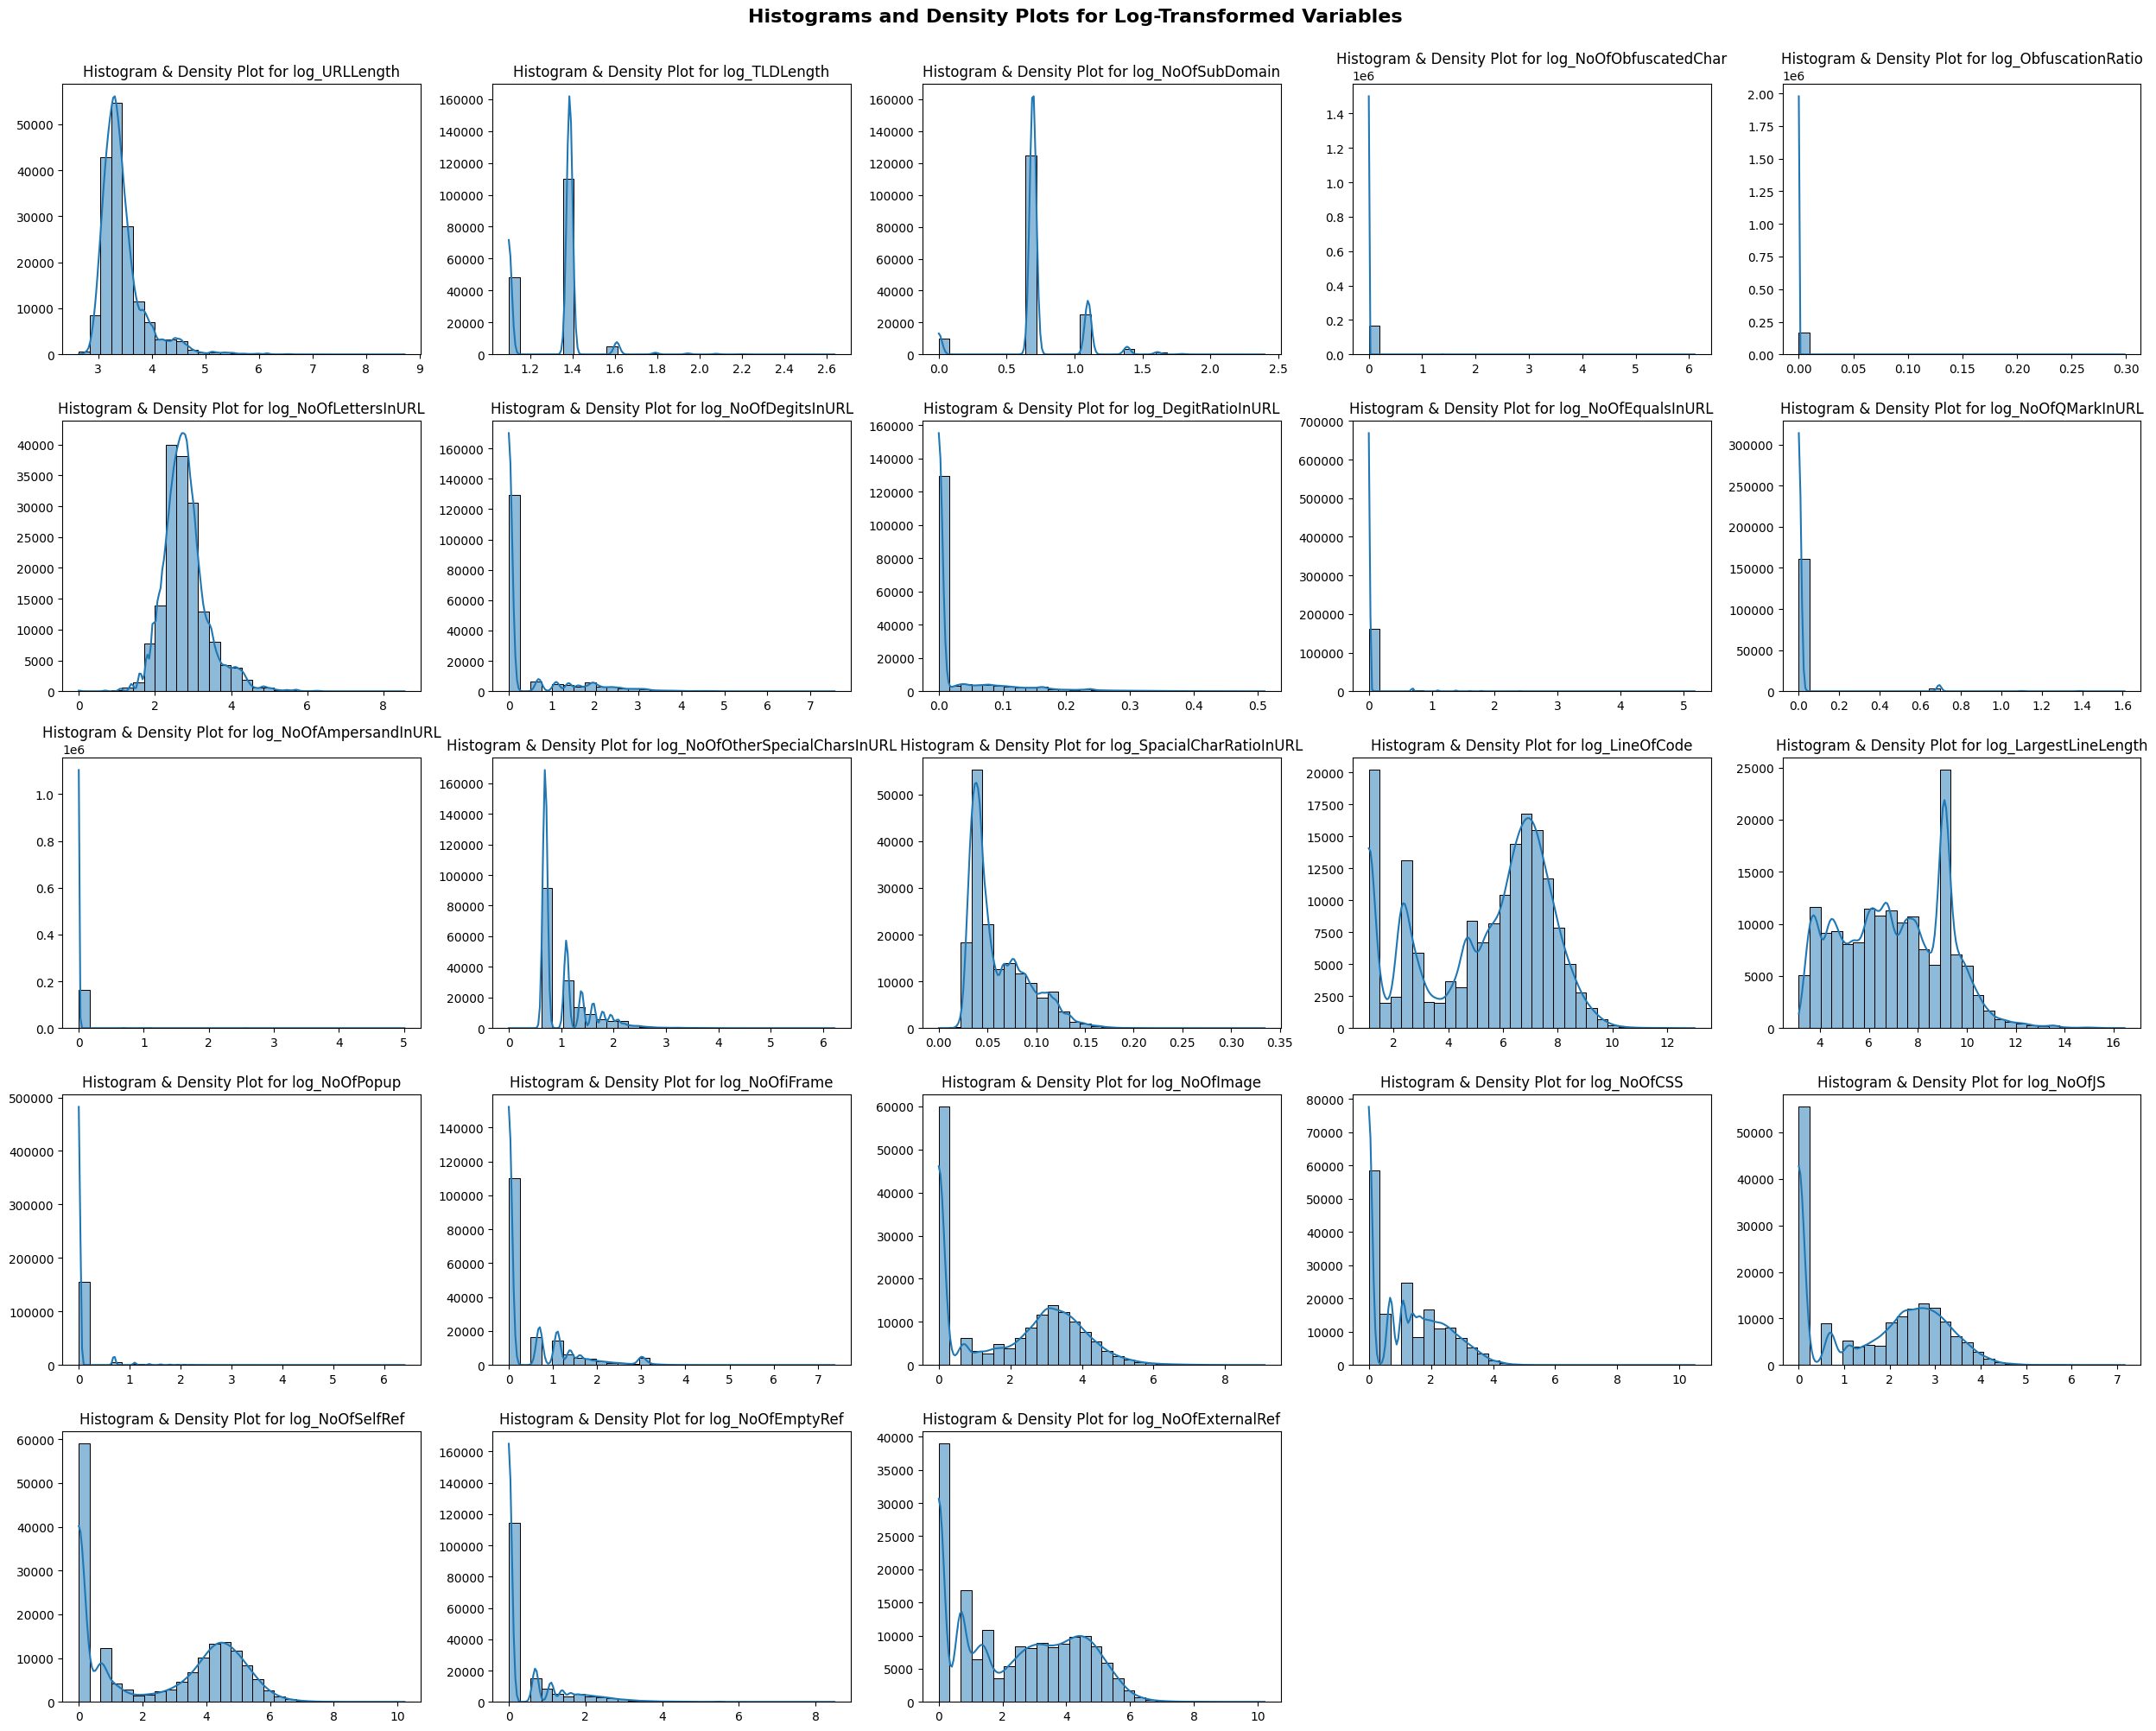

In [ ]:
# log-transformed variables
df_train_transformed = df_train.copy()
transform_variables = ['URLLength', 'TLDLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL',
                           'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 
                           'SpacialCharRatioInURL', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
                           'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']
for var in transform_variables:
    df_train_transformed[f"log_{var}"] = np.log1p(df_train_transformed[var])

# visualise log transformed variables
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Log-Transformed Variables', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(transform_variables):
    ax = axes[i]
    sns.histplot(data=df_train_transformed, x=f"log_{var_name}", kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for log_{var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(transform_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()


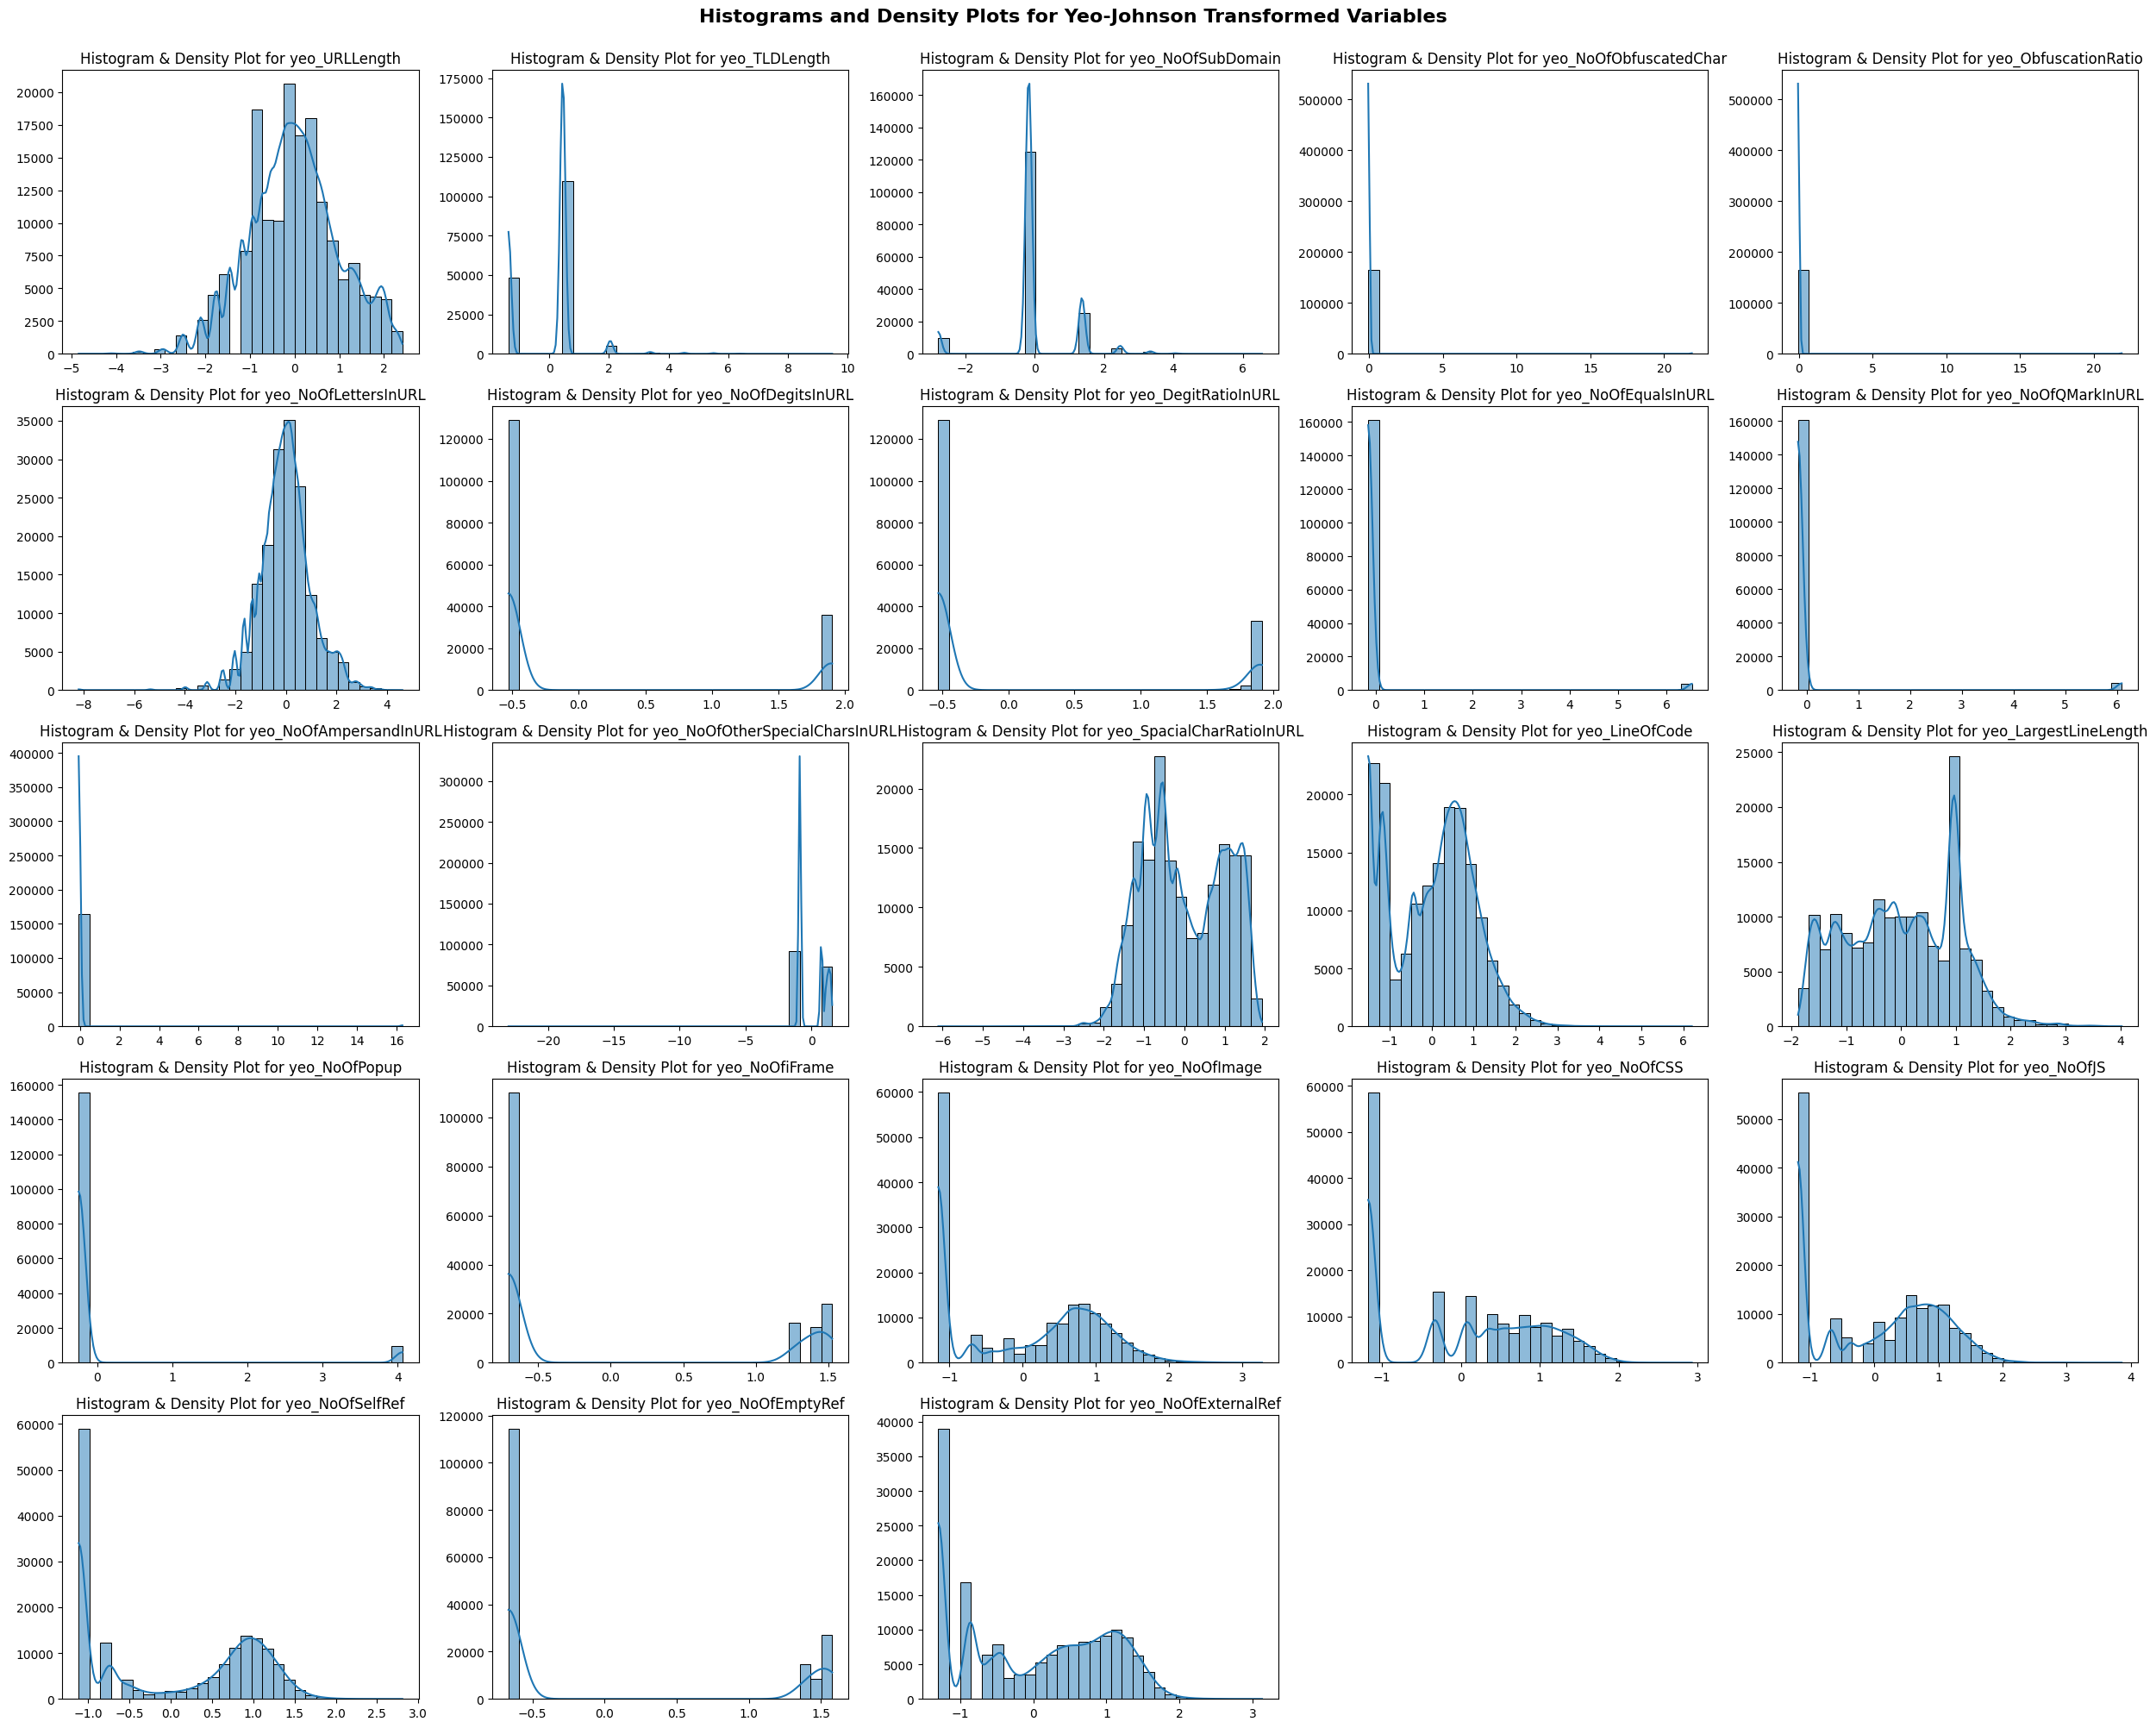

In [101]:
# Yeo-Johnson transformed variables
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_train_transformed[[f"yeo_{var}" for var in transform_variables]] = pt.fit_transform(df_train_transformed[transform_variables])

# visualise Yeo-Johnson transformed variables
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Yeo-Johnson Transformed Variables', fontsize=16, fontweight='bold', y=1)

for i, var_name in enumerate(transform_variables):
    ax = axes[i]
    sns.histplot(data=df_train_transformed, x=f"yeo_{var_name}", kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for yeo_{var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(transform_variables), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Insights:
- After trying log-transform and Yeo-Johnson transform (a form of box cox transformation that is more robust for making our data normal and at the same time it works well with zero and negative values), we see that some of the features like eg. `URLLength`, `NoOfLettersInURL` are now approximately normally distributed
- But there are some features like eg. `NoOfAmpersandInURL`, `NoOfQMarkInURL` that seems to be a discrete numerical variable instead of a continuous variable
- Also, some features like eg. `NoOfImage`, `NoOfJS` shows a strong peak at value = 0, while rest of the values show an approximately normal distribution

Plan: [to check on this]
- We can look at the number of unique values for these numerical variables to determine if it is discrete or continuous. For continuous, we can proceed with transformation to make them approximately normal, to be used for models like logistic regression. For discrete, we need to treat it as a categorical variable through one hot encoding or binning for models like logistic regression.
    - For discrete variables, if we leave values as it is, linear models like log regression can make linear assumptions which might not be accurate
- For those features with strong peaks at a specific value (eg. 0), we can create another boolean feature to better capture this relationship
    - Not needed for tree-based models

##### [3.1.2] Determine if numerical variables are discrete or continuous

In [86]:
check_numerical_vars = []
for col in numerical_variables:
    if col in df_train:
        num_unique = df_train[col].nunique()
        dtype = df_train[col].dtype
        check_numerical_vars.append({"Column": col, "Type": dtype, "Unique Values": num_unique})
    else:
        check_numerical_vars.append({"Column": col, "Type": "Not Found", "Unique Values": "N/A"})
check_numerical_vars_df = pd.DataFrame(check_numerical_vars)
print(check_numerical_vars_df.sort_values(by="Unique Values"))

                        Column     Type  Unique Values
23             NoOfURLRedirect    int64              2
24            NoOfSelfRedirect    int64              2
15              NoOfQMarkInURL    int64              5
7                NoOfSubDomain    int64             10
6                    TLDLength    int64             12
8           NoOfObfuscatedChar    int64             20
14             NoOfEqualsInURL    int64             22
16          NoOfAmpersandInURL    int64             30
17  NoOfOtherSpecialCharsInURL    int64             69
1                 DomainLength    int64             98
25                   NoOfPopup    int64            103
26                  NoOfiFrame    int64            105
9             ObfuscationRatio  float64            132
21       DomainTitleMatchScore  float64            145
12             NoOfDegitsInURL    int64            166
28                     NoOfCSS    int64            187
29                      NoOfJS    int64            226
18       S

Insights:
- For features like `NoOfURLRedirect`, `NoOfSelfRedirect`, `NoOfQMarkInURL`, `NoOfSubDomain`, `TLDLength`, `NoOfObfuscatedChar`, `NoOfEqualsInURL`, `NoOfAmpersandInURL`, they have relatively lower number of unique values

Plan:
- For these features, don't need to do additional transformation 

##### [3.1.3] Determine numerical columns with large peaks for certain value
- By visual inspection

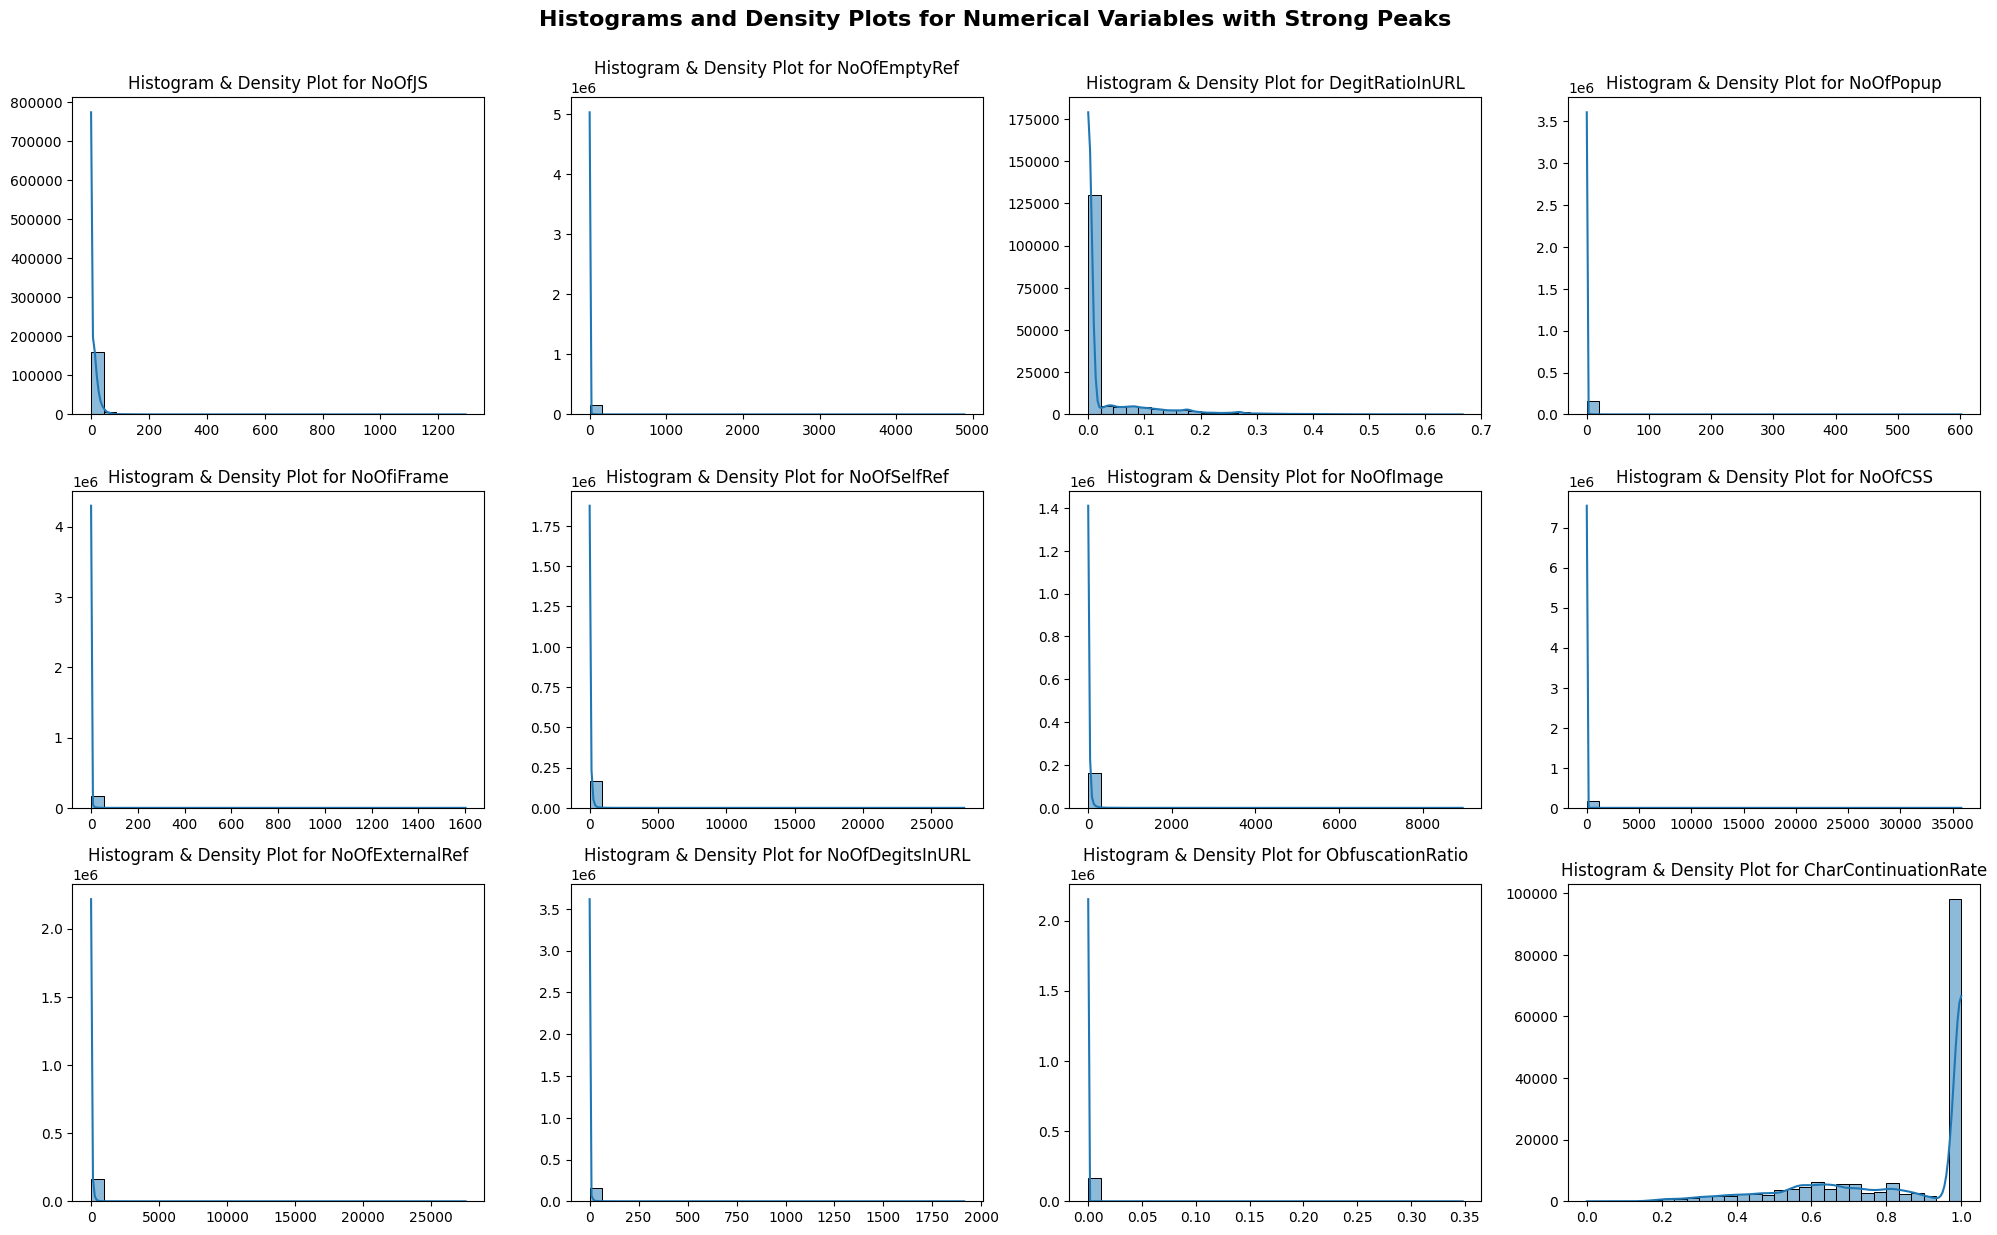

In [102]:
numerical_vars_low_unique_count = ['NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfQMarkInURL', 'NoOfSubDomain', 'TLDLength', 'NoOfObfuscatedChar', 'NoOfEqualsInURL', 'NoOfAmpersandInURL']
numerical_vars_with_strong_peaks = ['CharContinuationRate', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
                                    'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']
numerical_vars_with_strong_peaks = list(set(numerical_vars_with_strong_peaks) - set(numerical_vars_low_unique_count))

# plot out the histograms for numerical variables with strong peaks
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(4 * 5, 4 * 4))
axes = axes.flatten()
fig.suptitle('Histograms and Density Plots for Numerical Variables with Strong Peaks', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(numerical_vars_with_strong_peaks):
    ax = axes[i]
    sns.histplot(data=df_train, x=var_name, kde=True, ax=ax, bins=30)
    ax.set_title(f'Histogram & Density Plot for {var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('')   
for i in range(len(numerical_vars_with_strong_peaks), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()

#### [3.2] Outlier Analysis for numerical variables

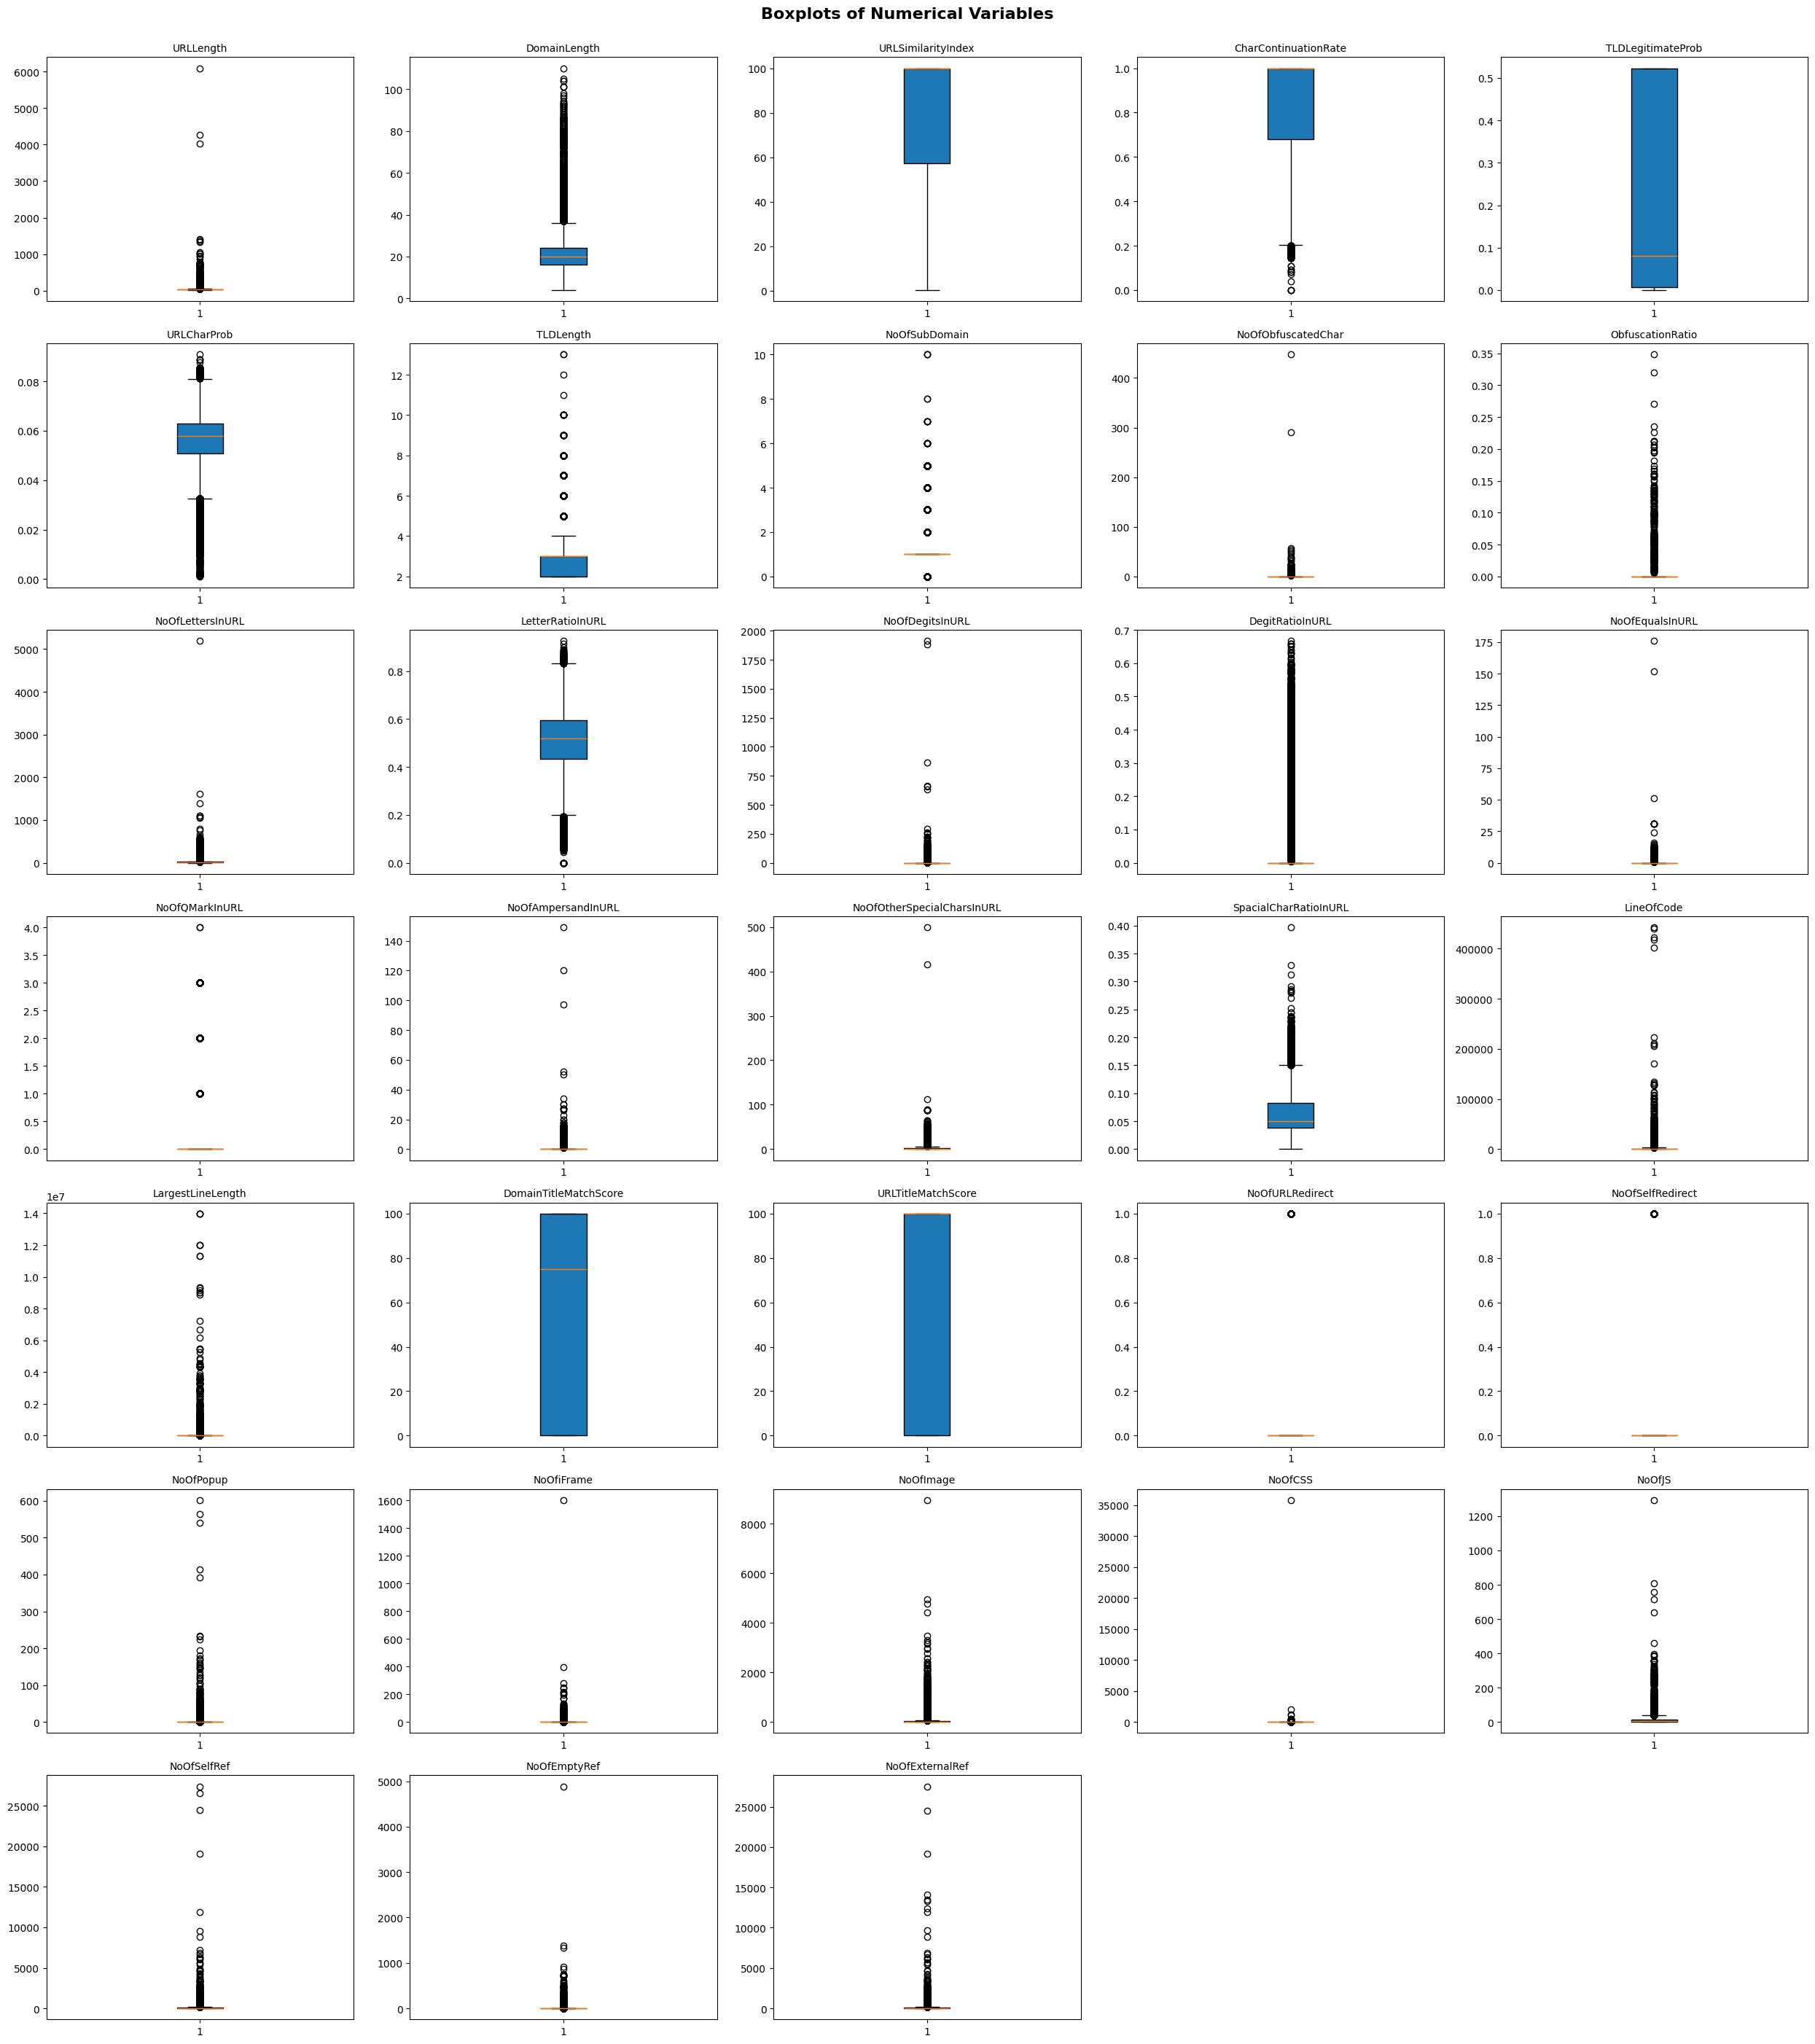

In [126]:
# plot boxplot for outlier detection
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(5 * 5, 7 * 4))
fig.suptitle('Boxplots of Numerical Variables', fontsize=16, fontweight='bold', y=1)
axes = axes.flatten()

for i, col in enumerate(numerical_variables):
    axes[i].boxplot(df_train[col].dropna(), vert=True, patch_artist=True, whis=1.5)
    axes[i].set_title(col, fontsize=10)

for i in range(len(numerical_variables), len(axes)):
    axes[i].set_visible(False)
    
plt.tight_layout()
plt.show()

Insights:
- There seems to be quite a lot of outliers for some of the columns

Plan:
- Do not remove outliers as they can contain important information
- For models like logistic regression where it is more sensitive to outliers, can use the log transformed features instead while for tree-based models, they are generally robust to outliers

#### [3.3] Descriptive Analysis for categorical / binary variables

In [ ]:
# select the categorical / binary variables
categorical_variables = df_train.select_dtypes(include=['bool']).columns.tolist() # exclude 'object' dtype since they are text fields

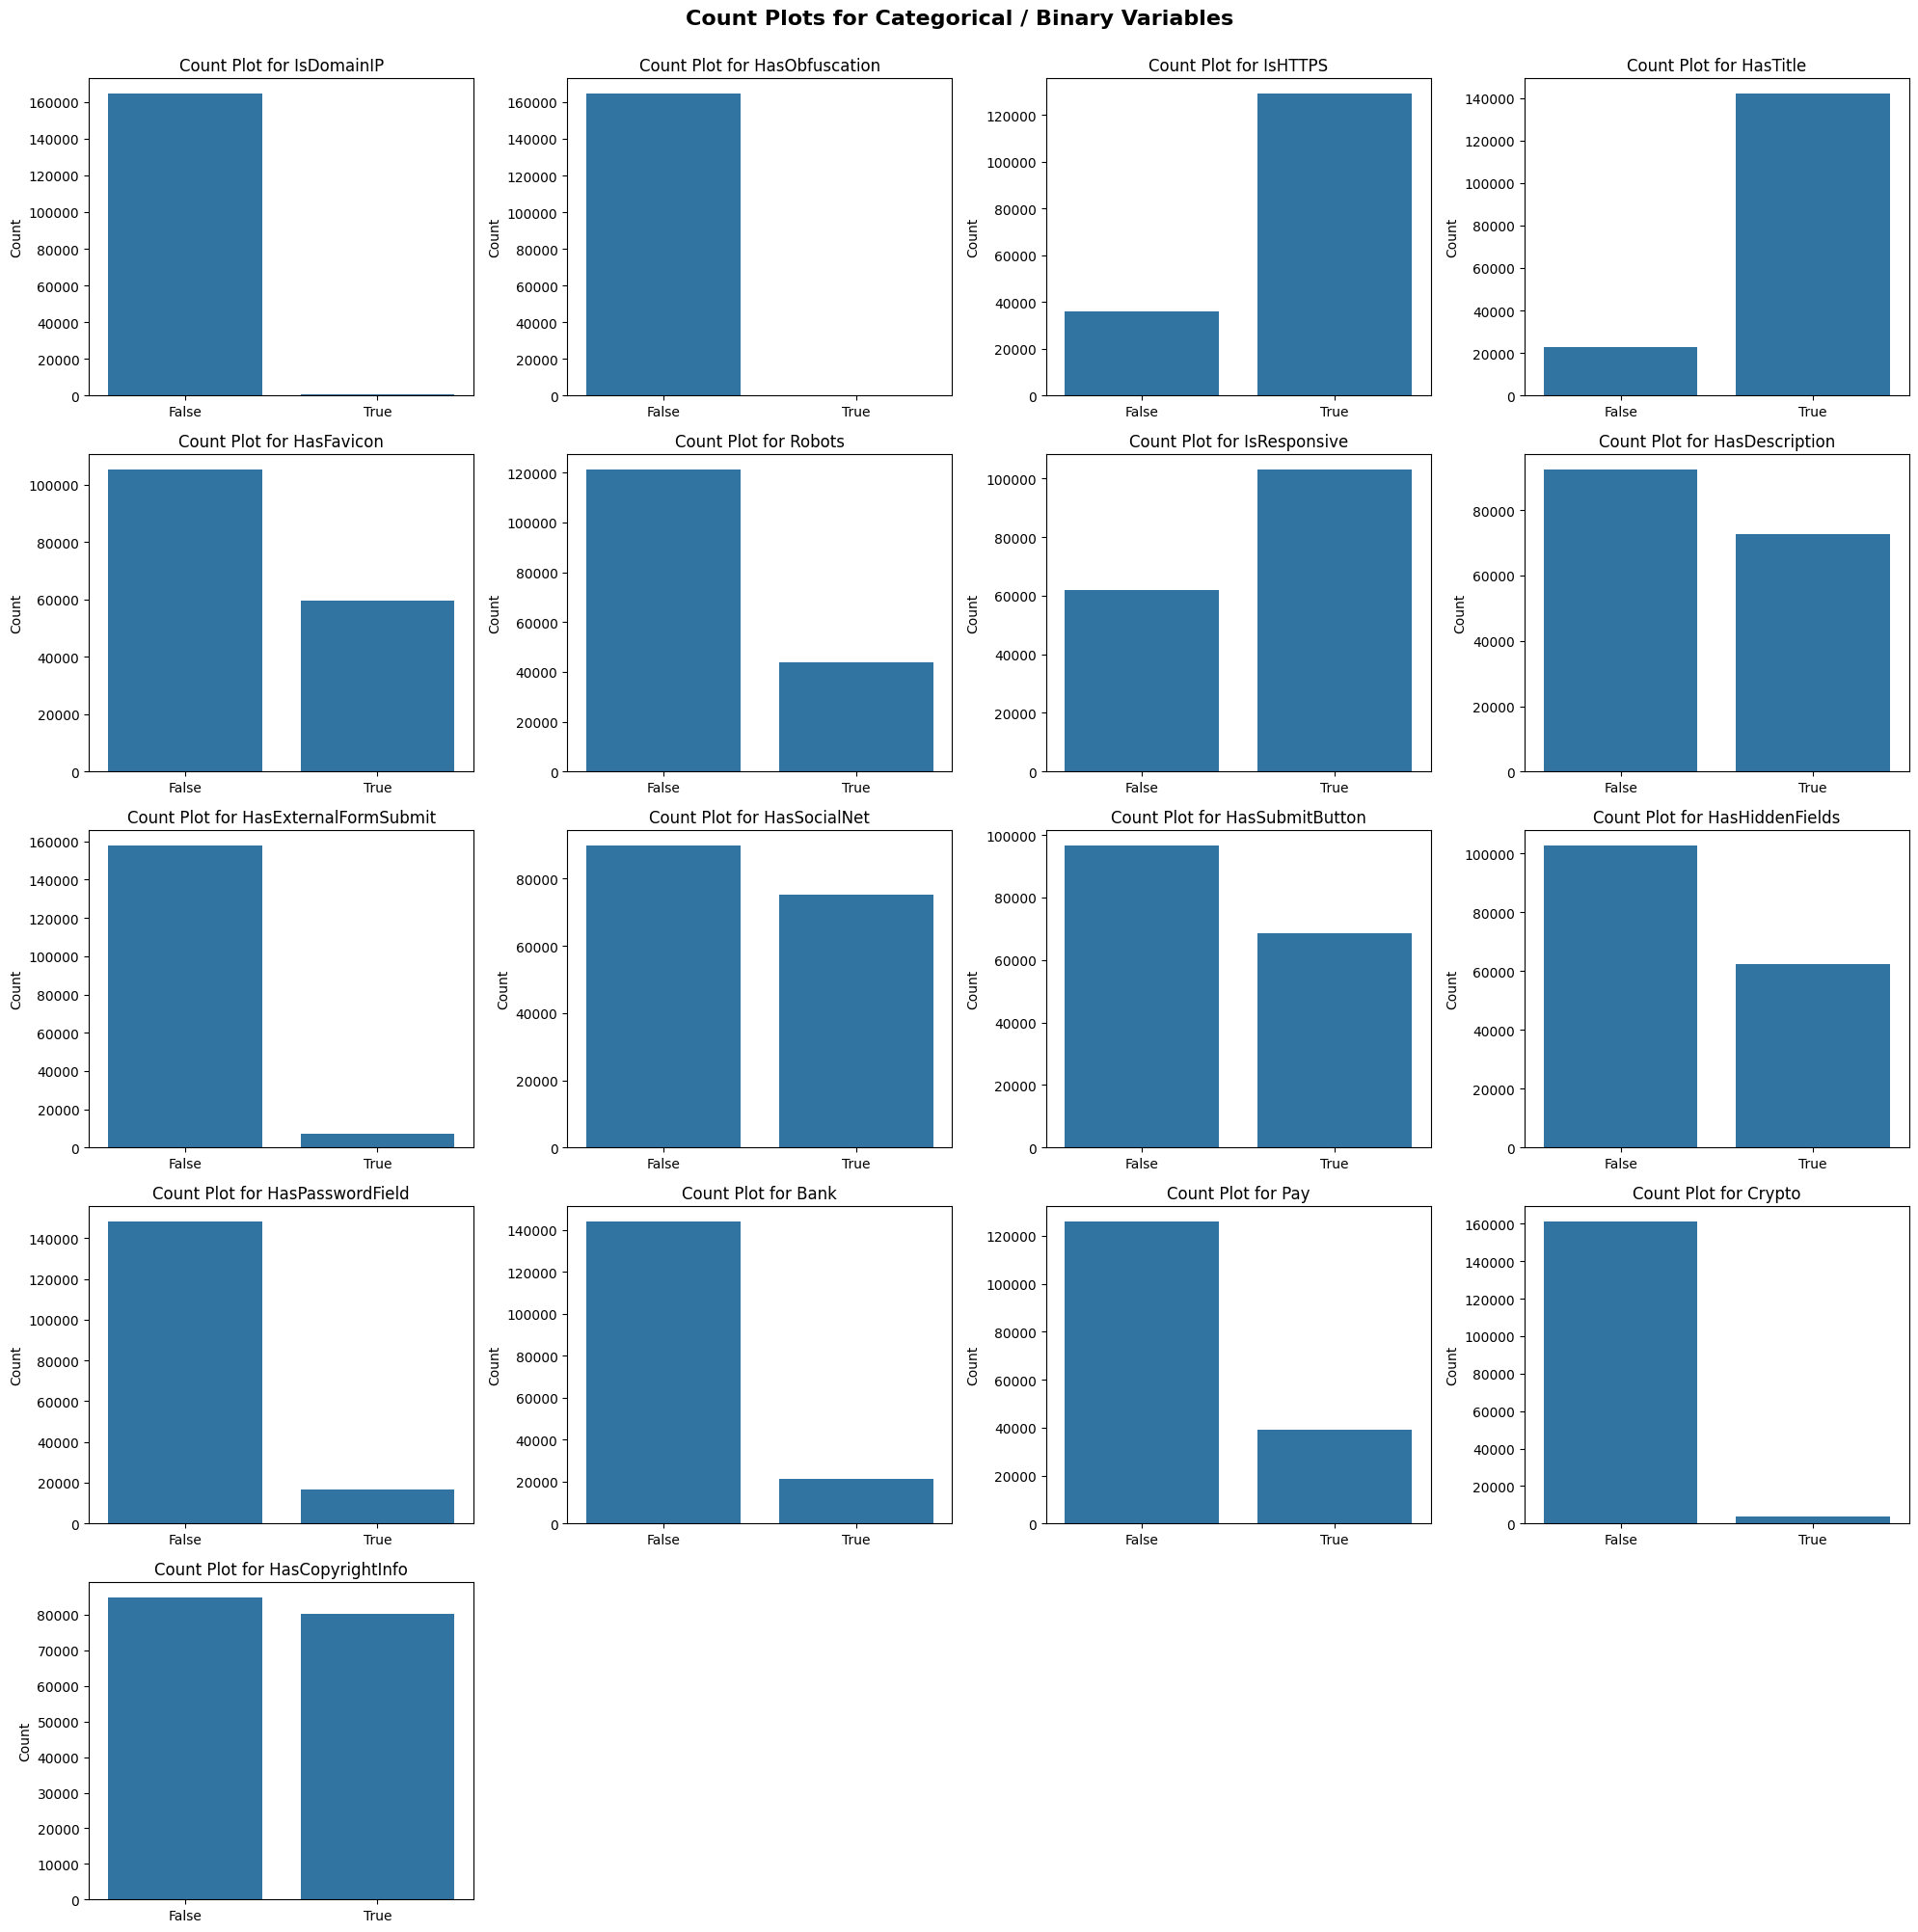

In [128]:
# plot count plots for categorical variables
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(4 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Count Plots for Categorical / Binary Variables', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(categorical_variables):
    ax = axes[i]
    sns.countplot(data=df_train, x=var_name, ax=ax)
    ax.set_title(f'Count Plot for {var_name}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
for i in range(len(categorical_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()

Insights:
- Generally distribution seems ok other than `IsDomainIP` and `HasObfuscation` where the count for 'True' is very low

#### [3.4] Correlation Analysis - Qualitative

Skipping URLSimilarityIndex: zero variance in at least one label group -> {0: 1, 1: 28732}
Skipping NoOfObfuscatedChar: zero variance in at least one label group -> {0: 1, 1: 20}
Skipping ObfuscationRatio: zero variance in at least one label group -> {0: 1, 1: 132}
Skipping NoOfEqualsInURL: zero variance in at least one label group -> {0: 1, 1: 22}
Skipping NoOfQMarkInURL: zero variance in at least one label group -> {0: 1, 1: 5}
Skipping NoOfAmpersandInURL: zero variance in at least one label group -> {0: 1, 1: 30}


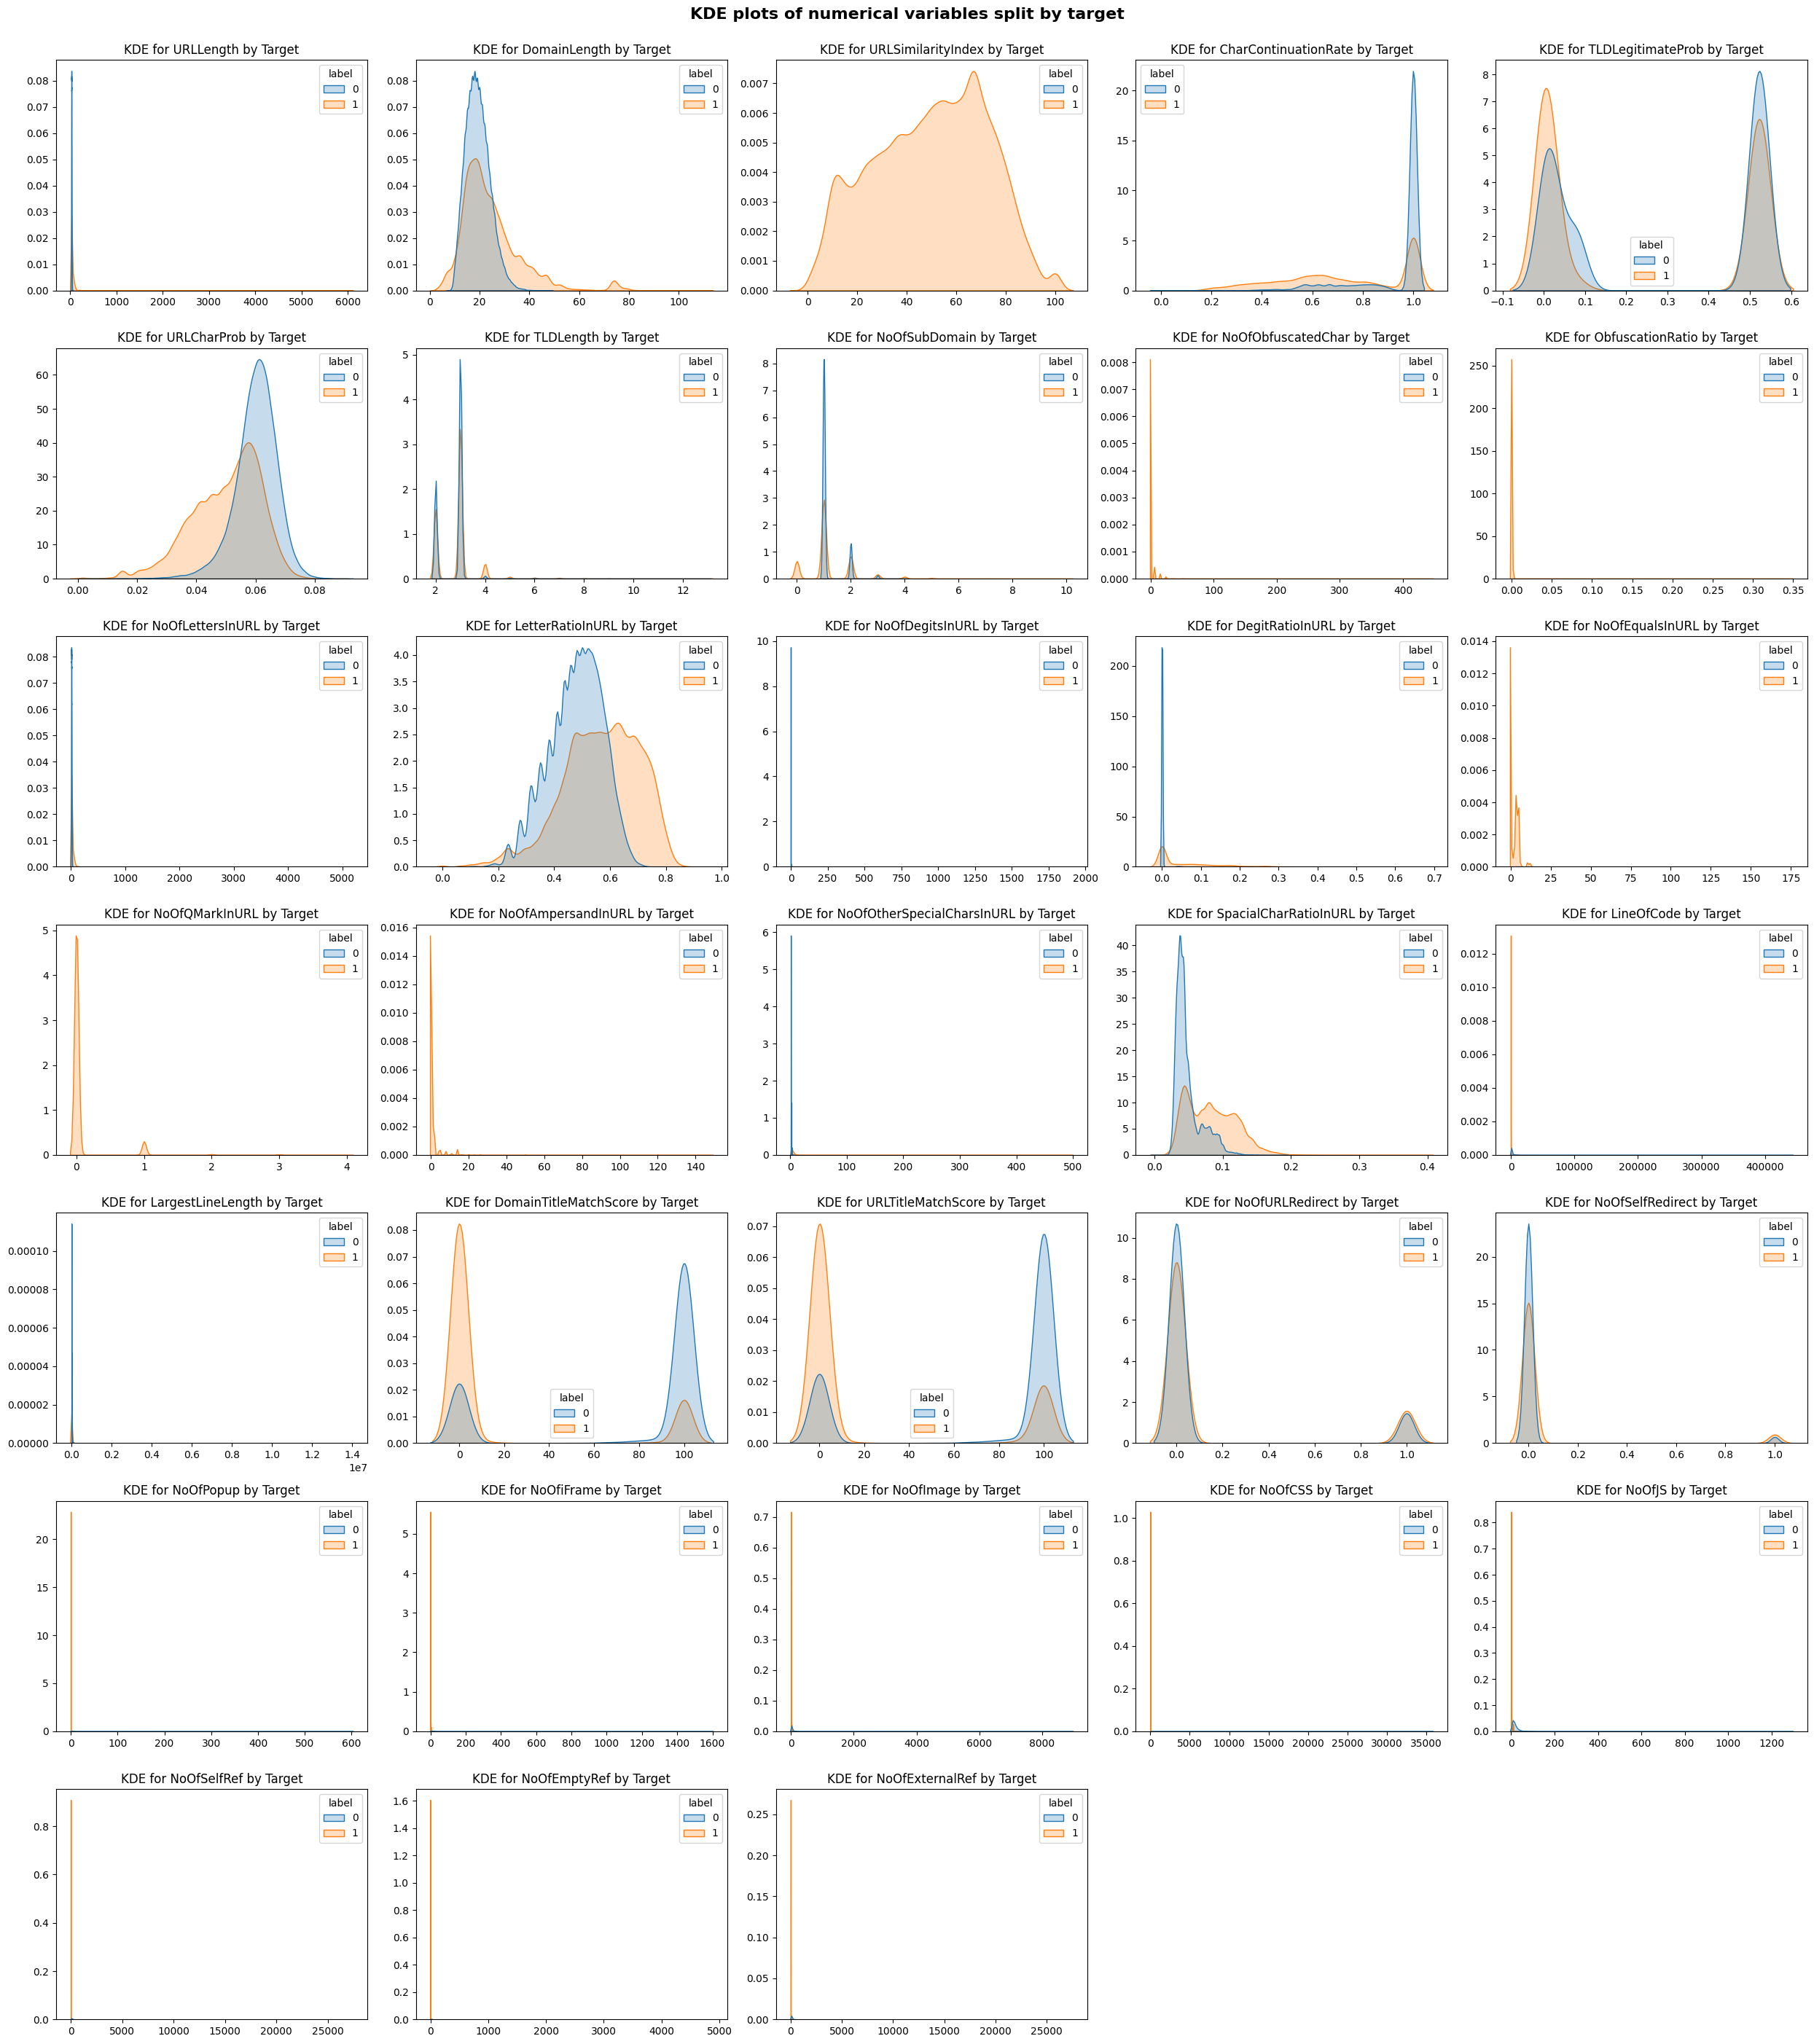

In [155]:
# plot histograms and kde for numerical variables split by label
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(5 * 5, 7 * 4))
axes = axes.flatten()
fig.suptitle('KDE plots of numerical variables split by target', fontsize=16, fontweight='bold', y=1)

for i, var_name in enumerate(numerical_variables):
    ax = axes[i]

    group_variances = df_train.groupby("label")[var_name].nunique()
    if (group_variances <= 1).any():  # if any group has only 1 unique value
        print(f"Skipping {var_name}: zero variance in at least one label group -> {group_variances.to_dict()}")
        sns.kdeplot(data=df_train, x=var_name, hue='label', ax=axes[i], fill=True, warn_singular=False)
        axes[i].set_title(f'Distribution of {var_name} by Target')
    else:
        sns.kdeplot(data=df_train, x=var_name, hue='label', ax=axes[i], fill=True, common_norm=False)
        axes[i].set_title(f'Distribution of {var_name} by Target')
    
    ax.set_title(f'KDE for {var_name} by Target')
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(numerical_variables), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Insights:
- `URLSimilarityIndex`, `NoOfObfuscatedChar`, `ObfuscationRatio`, `NoOfEqualsInURL`, `NoOfQMarkInURL`, `NoOfAmpersandInURL` only have 1 unique value in the positive label class
- `DomainTitleMatchScore`, `URLTitleMatchScore`, `TLDLegitimateProb` seems to be bimodal where each class dominates one peak, which suggests these are good predictors

Plan:
- For the features with no variance in one of the group, while this potentially suggests that these are very good features with strong predictive signals, would need to conduct further checks to ensure that this is not due to data leakage.

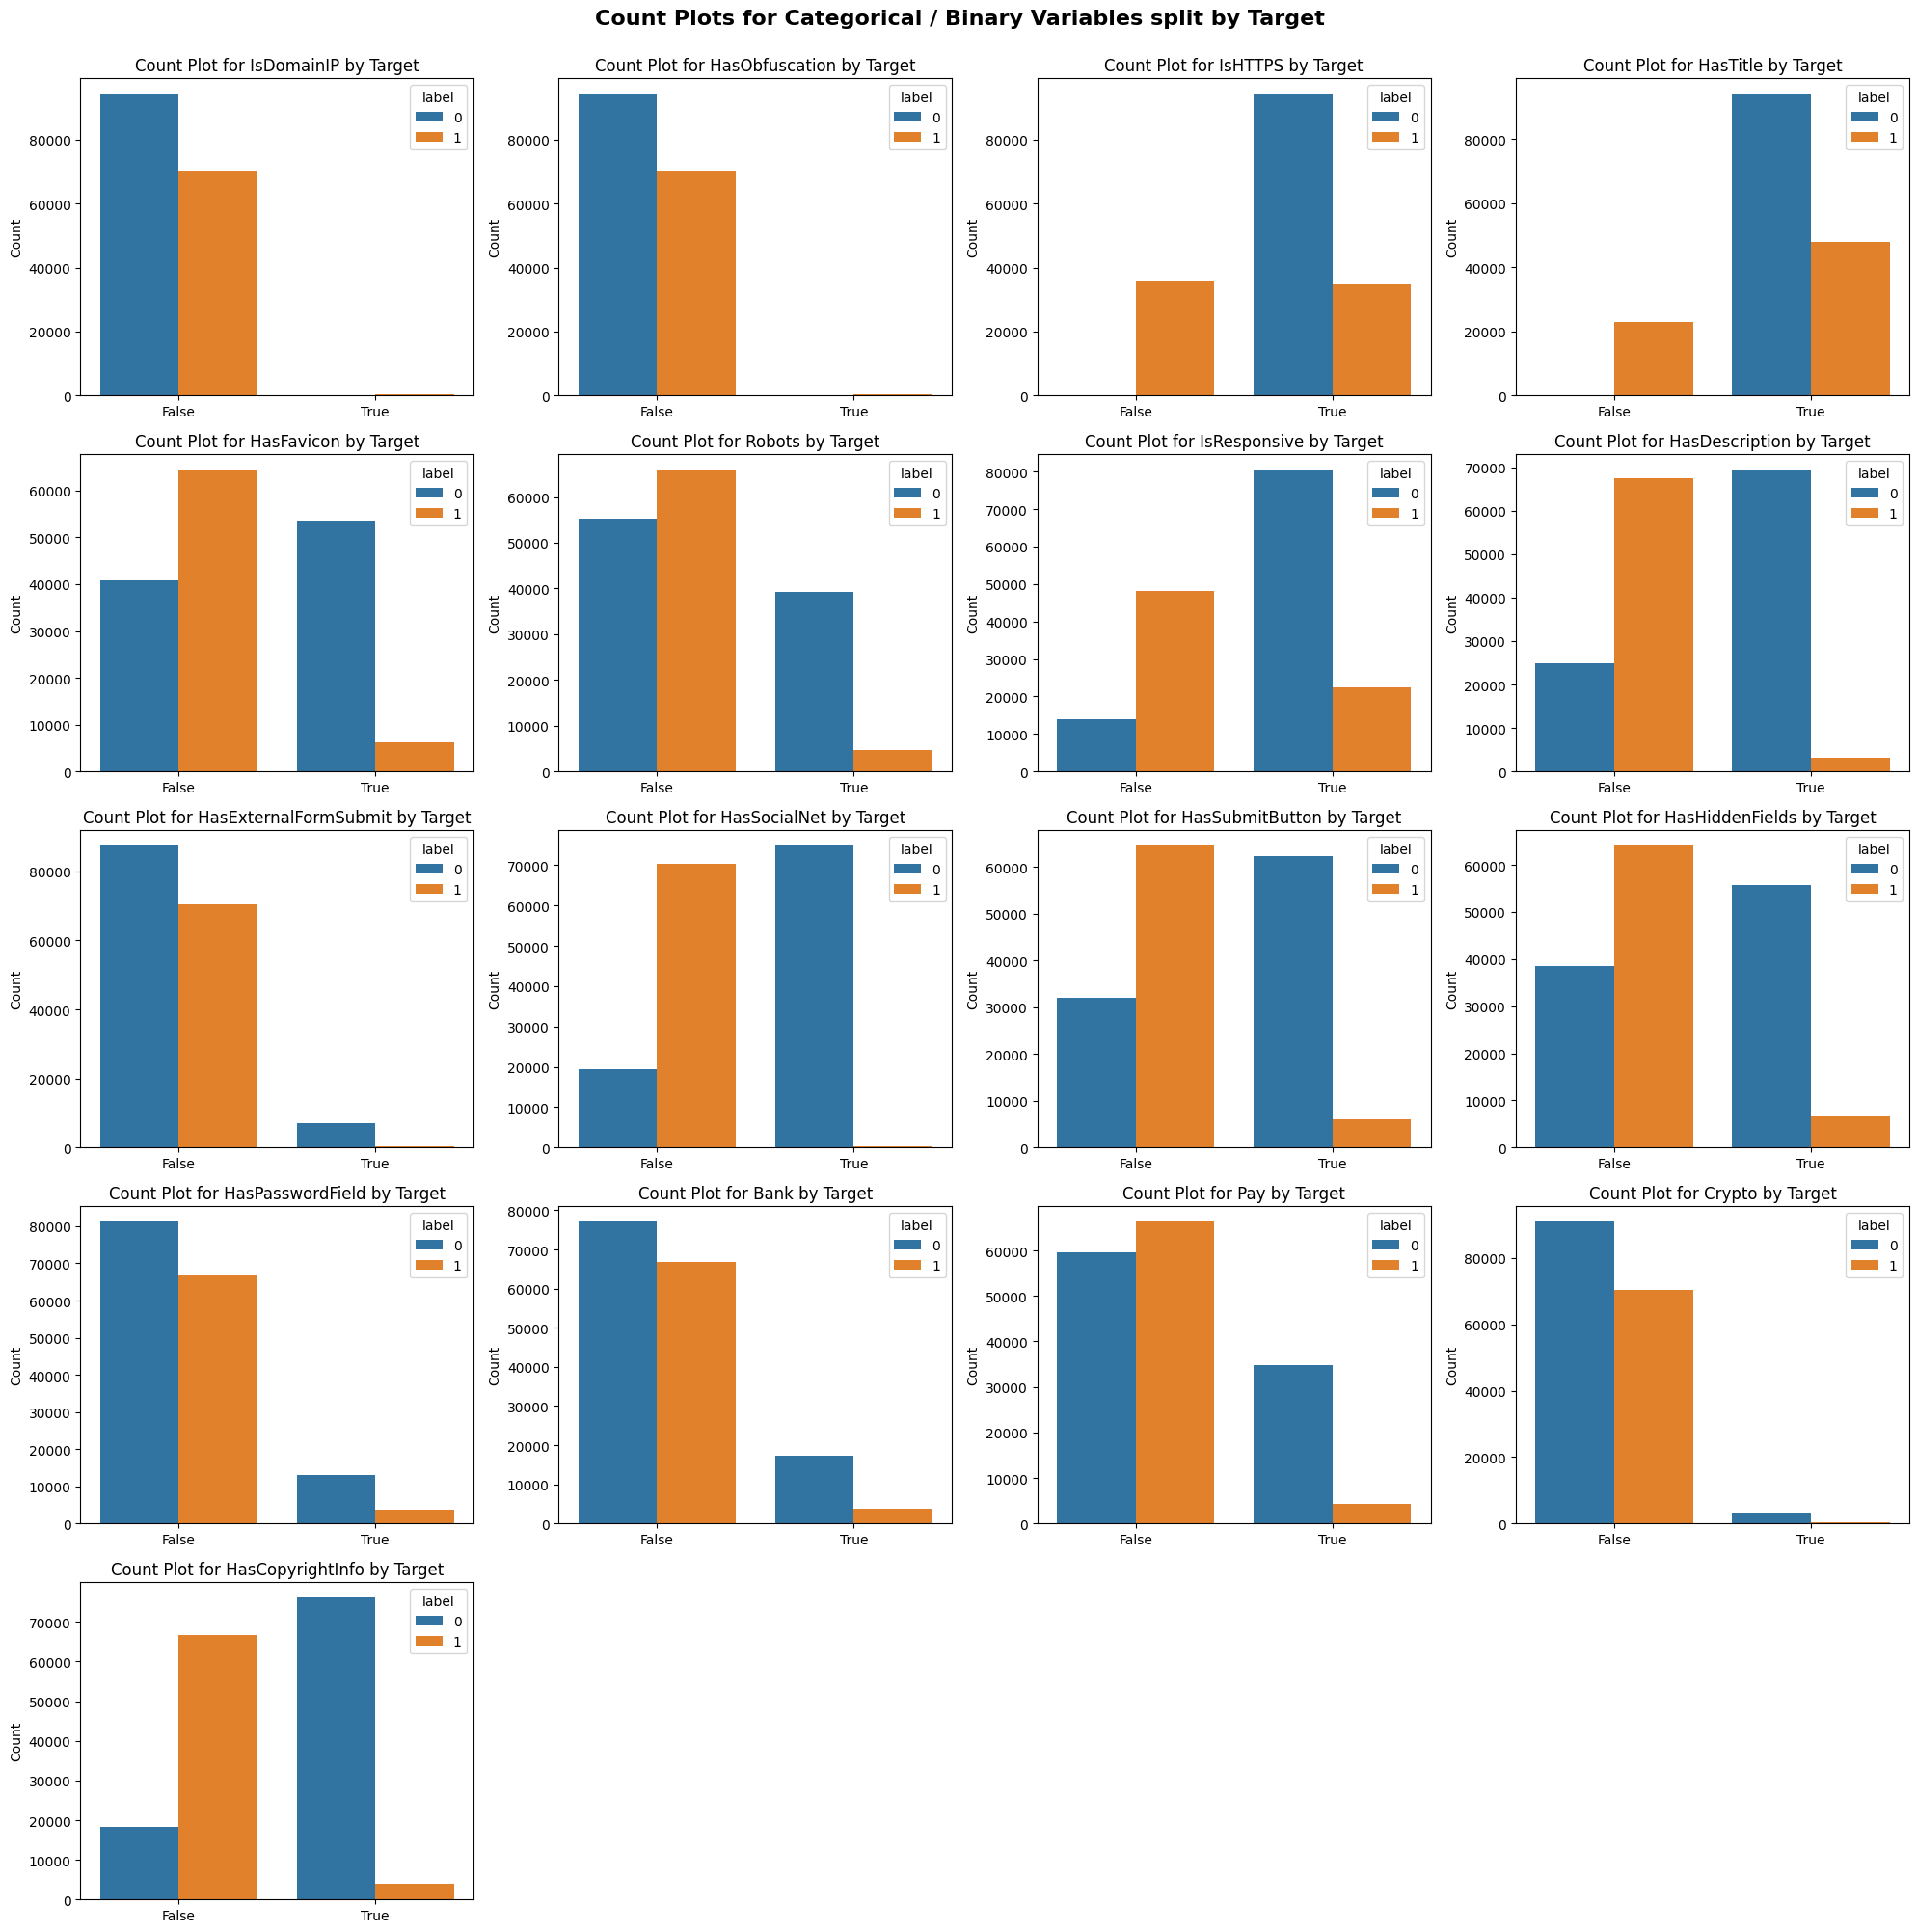

In [154]:
# plot count plot for categorical variables split by label
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(4 * 5, 5 * 4))
axes = axes.flatten()
fig.suptitle('Count Plots for Categorical / Binary Variables split by Target', fontsize=16, fontweight='bold', y=1)
for i, var_name in enumerate(categorical_variables):
    ax = axes[i]
    sns.countplot(data=df_train, x=var_name, hue='label', ax=ax)
    ax.set_title(f'Count Plot for {var_name} by Target')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
for i in range(len(categorical_variables), len(axes)):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
# print out columns where there is only 1 unique label in either group
for col in categorical_variables:
    group_variances = df_train.groupby("label")[col].nunique()
    if (group_variances <= 1).any(): 
        print(f"{col}: zero variance in at least one group -> {group_variances.to_dict()}")

IsDomainIP: zero variance in at least one group -> {0: 1, 1: 2}
HasObfuscation: zero variance in at least one group -> {0: 1, 1: 2}
IsHTTPS: zero variance in at least one group -> {0: 1, 1: 2}


Insights:
- Similar to the case for numerical, these 3 variables with no variance in at least one group shows that they are strong predictors. 

#### [3.5] Correlation Analysis - Quantitative

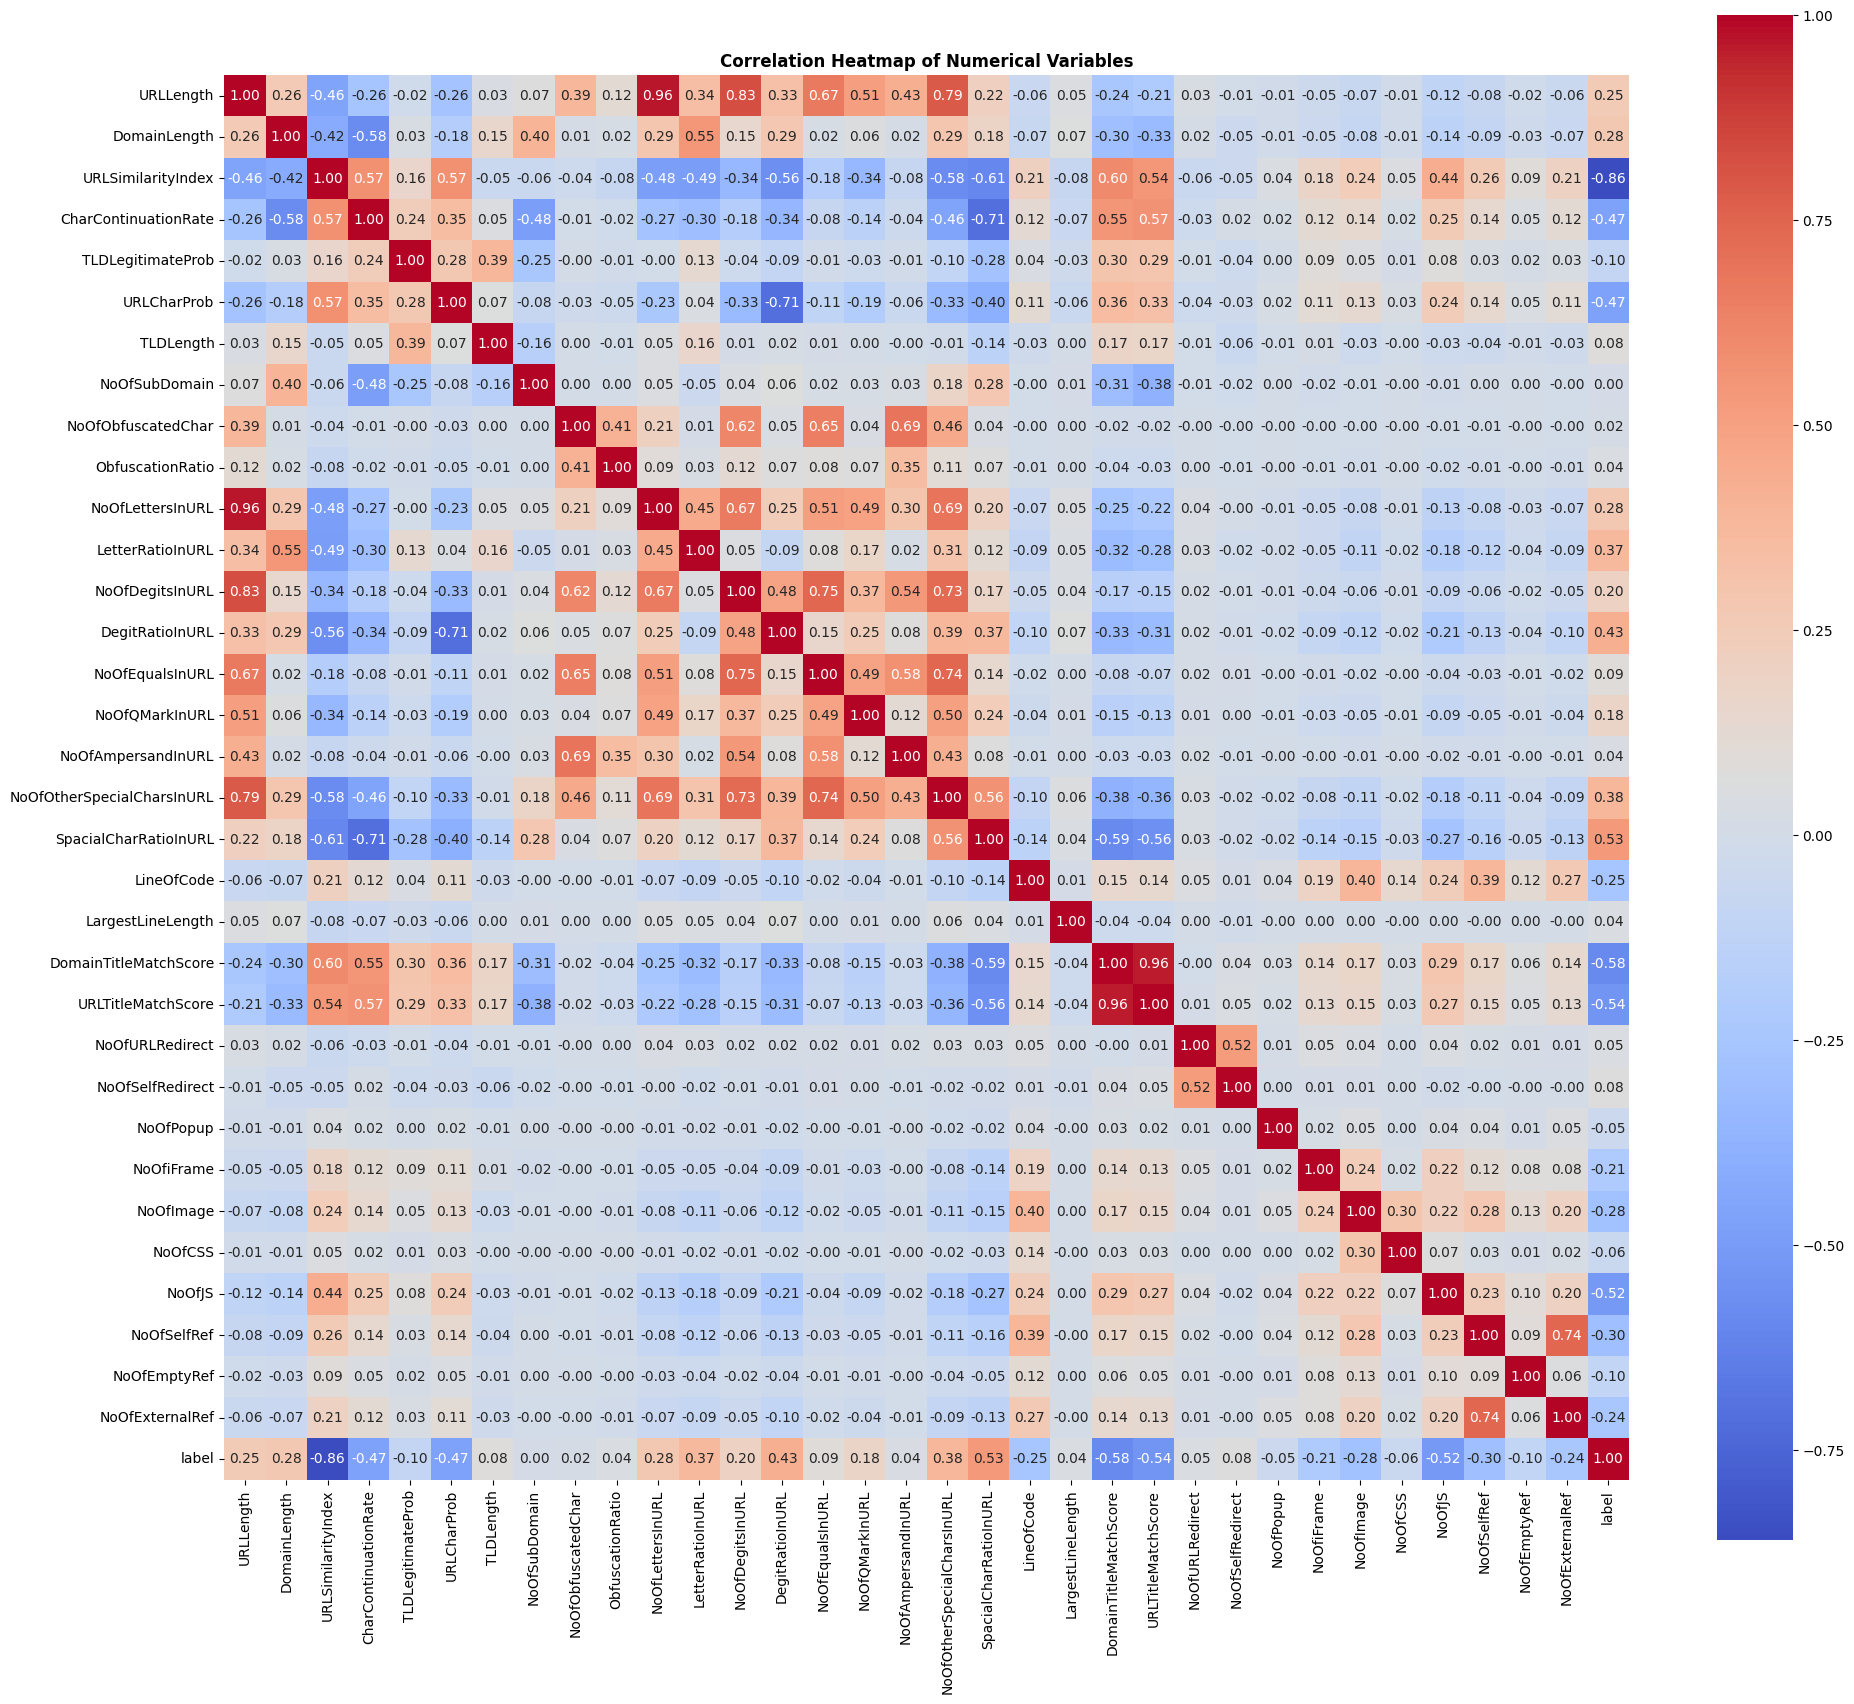

In [172]:
# pairwise correlation heatmap for numerical variables
plt.figure(figsize=(20, 20))
corr = df_train[numerical_variables + ['label']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Insights:
- `URLSimilarityIndex` is highly correlated with label (0.86).
- `NoOfLettersinURL` highly correlated with `URLLength` (0.96)
- `DomainTitleMatchScore` highly correlated with `URLTitleMatchScore` (0.96)

Plan:
- After looking at the introductory paper that came with the dataset, we realised that `URLSimilarityIndex` was a field used to determine the legitimacy of URLs where "A USI 100 shows a legitimate URL, and a USI close to 100 may indicate a phishing URL that looks very similar to a legitimate URL." As such, this makes sense that `URLSimilarityIndex` will be highly correlated with `label`. Thus for our project, we will be removing the `URLSimilarityIndex` column.
- For the features that are highly correlated with each other, this can introduce multicollinearity which will impact model's performance
    - For logistic regression, will have to remove one of the variables since multicollinearity affects linear models
    - For tree-based model, we can leave it as it is unaffected by multicollinearity
    - For deep learning, it is a good idea to remove it to improve speed of model training.

In [189]:
# compute information gain for categorical / boolean variables
def entropy(x):
    _, counts = np.unique(x, return_counts=True)
    probabilities = counts / len(x)
    return -np.sum(probabilities * np.log2(probabilities))


def conditional_entropy(x, y):
    y_values, y_counts = np.unique(y, return_counts=True)
    y_probabilities = y_counts / len(y)

    conditional_entropies = []
    for y_val, y_prob in zip(y_values, y_probabilities):
        x_given_y = x[y == y_val]
        conditional_entropies.append(entropy(x_given_y))

    return np.sum(y_probabilities * conditional_entropies)

# compute Entropy
categorical_variables_plus_label = categorical_variables + ['label']
entropies = pd.DataFrame([(x, entropy(df_train[x])) for x in categorical_variables_plus_label], columns=['cat1', 'H(cat1)'])

# compute Conditional Entropy
results = []
for cat1 in categorical_variables_plus_label:
    for cat2 in categorical_variables_plus_label:
        if cat1 != cat2:
            results.append((cat1, cat2, conditional_entropy(df_train[cat1], df_train[cat2])))

conditional_entropy_df = pd.DataFrame(results, columns=['cat1', 'cat2', 'H(cat1|cat2)'])

information_gain = entropies.merge(conditional_entropy_df)
information_gain['information gain'] = information_gain['H(cat1)'] - information_gain['H(cat1|cat2)']

information_gain

cat1   H(cat1)              cat2  H(cat1|cat2)  information gain
0    IsDomainIP  0.027205    HasObfuscation      0.027201          0.000004
1    IsDomainIP  0.027205           IsHTTPS      0.027082          0.000123
2    IsDomainIP  0.027205          HasTitle      0.027174          0.000030
3    IsDomainIP  0.027205        HasFavicon      0.026384          0.000821
4    IsDomainIP  0.027205            Robots      0.026266          0.000939
..          ...       ...               ...           ...               ...
301       label  0.985033  HasPasswordField      0.970125          0.014909
302       label  0.985033              Bank      0.956461          0.028572
303       label  0.985033               Pay      0.879766          0.105268
304       label  0.985033            Crypto      0.976719          0.008314
305       label  0.985033  HasCopyrightInfo      0.525831          0.459202

[306 rows x 5 columns]

/var/folders/70/_fptq3sn5mldlj0fhy1pvyh40000gn/T/ipykernel_26014/3538300260.py:1: FutureWarning: The provided callable <function sum at 0x108defba0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  information_gain.pivot_table(values='information gain', index='cat1', columns='cat2', aggfunc=np.sum)
/var/folders/70/_fptq3sn5mldlj0fhy1pvyh40000gn/T/ipykernel_26014/3538300260.py:4: FutureWarning: The provided callable <function sum at 0x108defba0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  hm = sns.heatmap(round(information_gain.pivot_table(index='cat1', columns='cat2', values='information gain', aggfunc=np.sum),2),


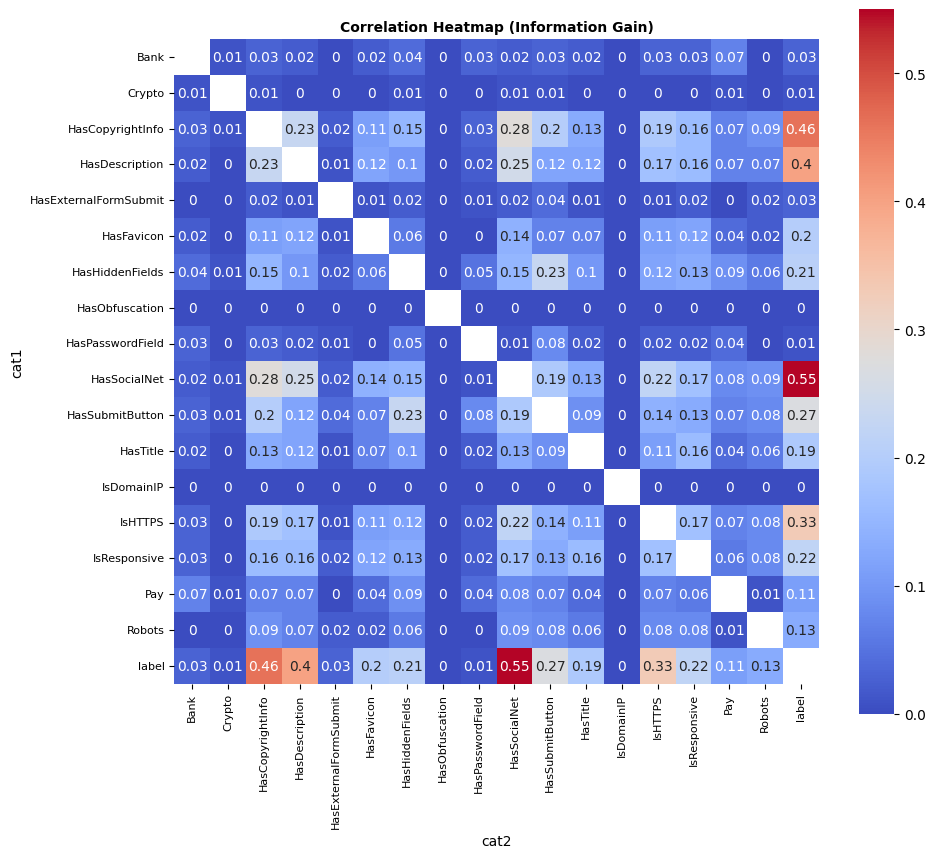

In [190]:
information_gain.pivot_table(values='information gain', index='cat1', columns='cat2', aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(10,10))

hm = sns.heatmap(round(information_gain.pivot_table(index='cat1', columns='cat2', values='information gain', aggfunc=np.sum),2),
                 ax=ax, cmap='coolwarm', annot=True, square=True, cbar_kws={"shrink": .8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
t = ax.set_title('Correlation Heatmap (Information Gain)', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

Insights:
- Generally between categorical variables, information gain is relatively low which means knowing one of the feature does not tell us much about the other feature. This is good as this means each feature provides unique and independent information to the model
- Looking at the information gain between feature and the label, features like `HasCopyrightInfo` and `HasSocialNet` have the largest information gain and are strong predictors of the label.

In [193]:
# statistical test (t-test) to check if there are any statistically significant differences in means between two target groups (label = 0 and label = 1)
results = []

for feature in numerical_variables:
    group0 = df_train[df_train.label == 0][feature] 
    group1 = df_train[df_train.label == 1][feature] 
    
    _, p_value = stats.ttest_ind(group0, group1, equal_var=False) 
    results.append((feature, p_value))

t_test_df = pd.DataFrame(results, columns=['Feature', 'P-value'])
t_test_df = t_test_df.sort_values('P-value')
t_test_df

/Users/sohjianhao/Documents/University/Course Resources/Y3S1/BT4012/Final Project/BT4012-Group-13/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Feature        P-value
0                    URLLength   0.000000e+00
30                 NoOfSelfRef   0.000000e+00
29                      NoOfJS   0.000000e+00
27                   NoOfImage   0.000000e+00
26                  NoOfiFrame   0.000000e+00
22          URLTitleMatchScore   0.000000e+00
21       DomainTitleMatchScore   0.000000e+00
19                  LineOfCode   0.000000e+00
18       SpacialCharRatioInURL   0.000000e+00
17  NoOfOtherSpecialCharsInURL   0.000000e+00
31                NoOfEmptyRef   0.000000e+00
15              NoOfQMarkInURL   0.000000e+00
13             DegitRatioInURL   0.000000e+00
32             NoOfExternalRef   0.000000e+00
11            LetterRatioInURL   0.000000e+00
10            NoOfLettersInURL   0.000000e+00
1                 DomainLength   0.000000e+00
2           URLSimilarityIndex   0.000000e+00
3         CharContinuationRate   0.000000e+00
5                  URLCharProb   0.000000e+00
12             NoOfDegitsInURL   0.000000e+00
4            TLDLegitimateProb   0.000000e+00
6                    TLDLength  8.791220e-220
14             NoOfEqualsInURL  1.302833e-204
24            NoOfSelfRedirect  1.071485e-190
28                     NoOfCSS  8.481765e-162
25                   NoOfPopup  5.034292e-111
23             NoOfURLRedirect   4.614225e-77
9             ObfuscationRatio   4.766842e-50
20           LargestLineLength   5.087881e-48
16          NoOfAmpersandInURL   3.734825e-39
8           NoOfObfuscatedChar   1.897637e-10
7                NoOfSubDomain   6.660811e-02

Insights:
- The numerical features have p-value < 0.05 suggesting that there is significant difference in means between both group (label = 0 and label = 1) and is likely to be informative as features

In [ ]:
# statistical test (chi square test) and check if there are any statistically significant associations between categorical variables and label
results = []
for feature in categorical_variables:
    contingency_table = pd.crosstab(df_train[feature], df_train['label'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append((feature, chi2, dof, p))
    
chi2_df = pd.DataFrame(results, columns=['Feature', 'Chi2', 'DoF', 'P-value']).sort_values('P-value')
chi2_df

Feature           Chi2  DoF        P-value
8   HasExternalFormSubmit    4663.848890    1   0.000000e+00
14                    Pay   21208.490585    1   0.000000e+00
13                   Bank    5976.309441    1   0.000000e+00
12       HasPasswordField    3188.322679    1   0.000000e+00
11        HasHiddenFields   42691.463999    1   0.000000e+00
10        HasSubmitButton   55186.404958    1   0.000000e+00
9            HasSocialNet  101206.755280    1   0.000000e+00
15                 Crypto    1615.682891    1   0.000000e+00
16       HasCopyrightInfo   90919.862628    1   0.000000e+00
6            IsResponsive   49374.307592    1   0.000000e+00
5                  Robots   25297.410506    1   0.000000e+00
4              HasFavicon   40219.573880    1   0.000000e+00
3                HasTitle   35038.156183    1   0.000000e+00
2                 IsHTTPS   61366.458685    1   0.000000e+00
7          HasDescription   78397.028200    1   0.000000e+00
0              IsDomainIP     601.795054    1  6.813363e-133
1          HasObfuscation     458.166553    1  1.204711e-101

Insights:
- All variables have p-value < 0.05 suggesting that the categorical features have a statistically significant association with the target

#### [3.6] Descriptive Analysis for textual features

In [191]:
# select the categorical / binary variables
text_variables = df_train.select_dtypes(include=['object']).columns.tolist()

In [192]:
text_variables

['URL', 'Domain', 'TLD', 'Title']

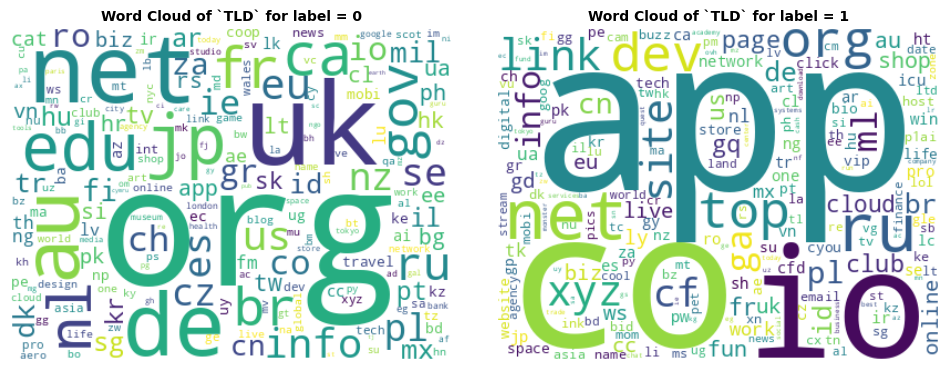

In [201]:
# plot word clouds for label 0 and label 1 to identify distinguishing keywords
# separate text by label
text0 = " ".join(df_train[df_train['label'] == 0]['TLD'].dropna())
text1 = " ".join(df_train[df_train['label'] == 1]['TLD'].dropna())

# create word cloud
wc0 = WordCloud(height=300, background_color='white', collocations=False).generate(text0)
wc1 = WordCloud(height=300, background_color='white', collocations=False).generate(text1)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# label = 0
axes[0].imshow(wc0, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud of `TLD` for label = 0", fontsize=10, fontweight='bold')
# label = 1
axes[1].imshow(wc1, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Word Cloud of `TLD` for label = 1", fontsize=10, fontweight='bold')

plt.subplots_adjust(wspace=0.1)
plt.show()

Insights:
- From the top level domains, we can clearly see that for each label class, there are certain unique keywords that show up which is not present in the class.

Plan:
- Can try to further split the domain and extend this analysis to the subdomain as well 

## [4] Processing before Modelling
- Additional Processing based on EDA insights
    - Log transform certain variables for log regression, SVM? (dont transform those lower unique counts?)
    - Convert to categorical through binning or one hot encoding for those with low unique count for numerical for log regression, SVM (TBC)
    - Create additional boolean cols for numerical cols with large peak at a certain value (likely for log regression and maybe neural networks)

- Feature Engineer